In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder,OrdinalEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import make_column_transformer, ColumnTransformer
import statsmodels.api as sm
from sklearn.feature_selection import mutual_info_regression
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
sns.set()

In [2]:
data = pd.read_csv('car_price_prediction.csv')
data.head()

,ID,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags
0,45654403,13328,1399,LEXUS,RX 450,2010,Jeep,Yes,Hybrid,3.5,186005 km,6.0,Automatic,4x4,04-May,Left wheel,Silver,12
1,44731507,16621,1018,CHEVROLET,Equinox,2011,Jeep,No,Petrol,3,192000 km,6.0,Tiptronic,4x4,04-May,Left wheel,Black,8
2,45774419,8467,-,HONDA,FIT,2006,Hatchback,No,Petrol,1.3,200000 km,4.0,Variator,Front,04-May,Right-hand drive,Black,2
3,45769185,3607,862,FORD,Escape,2011,Jeep,Yes,Hybrid,2.5,168966 km,4.0,Automatic,4x4,04-May,Left wheel,White,0
4,45809263,11726,446,HONDA,FIT,2014,Hatchback,Yes,Petrol,1.3,91901 km,4.0,Automatic,Front,04-May,Left wheel,Silver,4


In [3]:
df = data.copy()

# FEATURE ENGINEERING

## Understand Data

In [4]:
df.shape

(19237, 18)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19237 entries, 0 to 19236
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                19237 non-null  int64  
 1   Price             19237 non-null  int64  
 2   Levy              19237 non-null  object 
 3   Manufacturer      19237 non-null  object 
 4   Model             19237 non-null  object 
 5   Prod. year        19237 non-null  int64  
 6   Category          19237 non-null  object 
 7   Leather interior  19237 non-null  object 
 8   Fuel type         19237 non-null  object 
 9   Engine volume     19237 non-null  object 
 10  Mileage           19237 non-null  object 
 11  Cylinders         19237 non-null  float64
 12  Gear box type     19237 non-null  object 
 13  Drive wheels      19237 non-null  object 
 14  Doors             19237 non-null  object 
 15  Wheel             19237 non-null  object 
 16  Color             19237 non-null  object

In [6]:
df.describe().round(2)

,ID,Price,Prod. year,Cylinders,Airbags
count,19237.00,19237.00,19237.00,19237.00,19237.00
mean,45576535.89,18555.93,2010.91,4.58,6.58
std,936591.42,190581.27,5.67,1.20,4.32
min,20746880.00,1.00,1939.00,1.00,0.00
25%,45698374.00,5331.00,2009.00,4.00,4.00
50%,45772308.00,13172.00,2012.00,4.00,6.00
75%,45802036.00,22075.00,2015.00,4.00,12.00
max,45816654.00,26307500.00,2020.00,16.00,16.00


* <font color='brown'>**Loos like Price is highly skewed to the right**</font>

In [7]:
df.describe(include='object')

,Levy,Manufacturer,Model,Category,Leather interior,Fuel type,Engine volume,Mileage,Gear box type,Drive wheels,Doors,Wheel,Color
count,19237,19237,19237,19237,19237,19237,19237,19237,19237,19237,19237,19237,19237
unique,559,65,1590,11,2,7,107,7687,4,3,3,2,16
top,-,HYUNDAI,Prius,Sedan,Yes,Petrol,2,0 km,Automatic,Front,04-May,Left wheel,Black
freq,5819,3769,1083,8736,13954,10150,3916,721,13514,12874,18332,17753,5033


* <font color = 'brown'>**levy, Engine volume and Mileage must convert to the numeric values**</font>
* <font color = 'brown'>**Instead of prod.year, age of the car can be calculate**</font>

## Data preprossessing and Cleaning

In [8]:
df['Levy'].unique()

array(['1399', '1018', '-', '862', '446', '891', '761', '751', '394',
       '1053', '1055', '1079', '810', '2386', '1850', '531', '586',
       '1249', '2455', '583', '1537', '1288', '915', '1750', '707',
       '1077', '1486', '1091', '650', '382', '1436', '1194', '503',
       '1017', '1104', '639', '629', '919', '781', '530', '640', '765',
       '777', '779', '934', '769', '645', '1185', '1324', '830', '1187',
       '1111', '760', '642', '1604', '1095', '966', '473', '1138', '1811',
       '988', '917', '1156', '687', '11714', '836', '1347', '2866',
       '1646', '259', '609', '697', '585', '475', '690', '308', '1823',
       '1361', '1273', '924', '584', '2078', '831', '1172', '893', '1872',
       '1885', '1266', '447', '2148', '1730', '730', '289', '502', '333',
       '1325', '247', '879', '1342', '1327', '1598', '1514', '1058',
       '738', '1935', '481', '1522', '1282', '456', '880', '900', '798',
       '1277', '442', '1051', '790', '1292', '1047', '528', '1211',
       

In [9]:
df['Levy'] = [0 if i=='-' else int(i) for i in df['Levy']]

In [10]:
df['Levy'].dtype

dtype('int64')

In [11]:
df['Engine volume'].unique()

array(['3.5', '3', '1.3', '2.5', '2', '1.8', '2.4', '4', '1.6', '3.3',
       '2.0 Turbo', '2.2 Turbo', '4.7', '1.5', '4.4', '3.0 Turbo',
       '1.4 Turbo', '3.6', '2.3', '1.5 Turbo', '1.6 Turbo', '2.2',
       '2.3 Turbo', '1.4', '5.5', '2.8 Turbo', '3.2', '3.8', '4.6', '1.2',
       '5', '1.7', '2.9', '0.5', '1.8 Turbo', '2.4 Turbo', '3.5 Turbo',
       '1.9', '2.7', '4.8', '5.3', '0.4', '2.8', '3.2 Turbo', '1.1',
       '2.1', '0.7', '5.4', '1.3 Turbo', '3.7', '1', '2.5 Turbo', '2.6',
       '1.9 Turbo', '4.4 Turbo', '4.7 Turbo', '0.8', '0.2 Turbo', '5.7',
       '4.8 Turbo', '4.6 Turbo', '6.7', '6.2', '1.2 Turbo', '3.4',
       '1.7 Turbo', '6.3 Turbo', '2.7 Turbo', '4.3', '4.2', '2.9 Turbo',
       '0', '4.0 Turbo', '20', '3.6 Turbo', '0.3', '3.7 Turbo', '5.9',
       '5.5 Turbo', '0.2', '2.1 Turbo', '5.6', '6', '0.7 Turbo',
       '0.6 Turbo', '6.8', '4.5', '0.6', '7.3', '0.1', '1.0 Turbo', '6.3',
       '4.5 Turbo', '0.8 Turbo', '4.2 Turbo', '3.1', '5.0 Turbo', '6.4',
       '3

In [12]:
df['Engine volume'] = [float(i.split()[0]) for i in df['Engine volume']]

In [13]:
df['Engine volume'].dtype

dtype('float64')

In [14]:
df['Mileage'].unique()

array(['186005 km', '192000 km', '200000 km', ..., '140607 km',
       '307325 km', '186923 km'], dtype=object)

In [15]:
df['Mileage'] = [float(i.split()[0]) for i in df['Mileage']]

In [16]:
df['Engine volume'].dtype

dtype('float64')

In [17]:
df['Doors'].unique()

array(['04-May', '02-Mar', '>5'], dtype=object)

* <font color = 'brown'>**Looks like there was a data entry error. 4 doors and 2 doors are entered as dates.**</font>

In [18]:
df['Doors'] = df['Doors'].map({'04-May':'4','02-Mar':'2', '>5': '>5'})

In [19]:
df['Doors'].unique()

array(['4', '2', '>5'], dtype=object)

In [21]:
df['age']=2023-df['Prod. year']

In [23]:
df.head()

,ID,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags,age
0,45654403,13328,1399,LEXUS,RX 450,2010,Jeep,Yes,Hybrid,3.5,186005.0,6.0,Automatic,4x4,4,Left wheel,Silver,12,13
1,44731507,16621,1018,CHEVROLET,Equinox,2011,Jeep,No,Petrol,3.0,192000.0,6.0,Tiptronic,4x4,4,Left wheel,Black,8,12
2,45774419,8467,0,HONDA,FIT,2006,Hatchback,No,Petrol,1.3,200000.0,4.0,Variator,Front,4,Right-hand drive,Black,2,17
3,45769185,3607,862,FORD,Escape,2011,Jeep,Yes,Hybrid,2.5,168966.0,4.0,Automatic,4x4,4,Left wheel,White,0,12
4,45809263,11726,446,HONDA,FIT,2014,Hatchback,Yes,Petrol,1.3,91901.0,4.0,Automatic,Front,4,Left wheel,Silver,4,9


In [24]:
df.drop('Prod. year',axis=1, inplace=True)

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19237 entries, 0 to 19236
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                19237 non-null  int64  
 1   Price             19237 non-null  int64  
 2   Levy              19237 non-null  int64  
 3   Manufacturer      19237 non-null  object 
 4   Model             19237 non-null  object 
 5   Category          19237 non-null  object 
 6   Leather interior  19237 non-null  object 
 7   Fuel type         19237 non-null  object 
 8   Engine volume     19237 non-null  float64
 9   Mileage           19237 non-null  float64
 10  Cylinders         19237 non-null  float64
 11  Gear box type     19237 non-null  object 
 12  Drive wheels      19237 non-null  object 
 13  Doors             19237 non-null  object 
 14  Wheel             19237 non-null  object 
 15  Color             19237 non-null  object 
 16  Airbags           19237 non-null  int64 

## Handling Missing Values

In [26]:
df.isna().sum()

ID                  0
Price               0
Levy                0
Manufacturer        0
Model               0
Category            0
Leather interior    0
Fuel type           0
Engine volume       0
Mileage             0
Cylinders           0
Gear box type       0
Drive wheels        0
Doors               0
Wheel               0
Color               0
Airbags             0
age                 0
dtype: int64

* <font color = 'brown'>**No missing values in the data set**</font>

## Handling Duplicates

In [27]:
df.duplicated().sum()

313

* <font color = 'brown'>**There are 313 Duplicates**</font>

In [28]:
df.drop_duplicates(inplace=True)

In [29]:
df.duplicated().sum()

0

In [30]:
df.drop('ID',axis=1,inplace=True) # Here ID column was dropped because there is no importance of the column

In [31]:
df = df.reset_index(drop=True)

In [32]:
df

,Price,Levy,Manufacturer,Model,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags,age
0,13328,1399,LEXUS,RX 450,Jeep,Yes,Hybrid,3.5,186005.0,6.0,Automatic,4x4,4,Left wheel,Silver,12,13
1,16621,1018,CHEVROLET,Equinox,Jeep,No,Petrol,3.0,192000.0,6.0,Tiptronic,4x4,4,Left wheel,Black,8,12
2,8467,0,HONDA,FIT,Hatchback,No,Petrol,1.3,200000.0,4.0,Variator,Front,4,Right-hand drive,Black,2,17
3,3607,862,FORD,Escape,Jeep,Yes,Hybrid,2.5,168966.0,4.0,Automatic,4x4,4,Left wheel,White,0,12
4,11726,446,HONDA,FIT,Hatchback,Yes,Petrol,1.3,91901.0,4.0,Automatic,Front,4,Left wheel,Silver,4,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18919,8467,0,MERCEDES-BENZ,CLK 200,Coupe,Yes,CNG,2.0,300000.0,4.0,Manual,Rear,2,Left wheel,Silver,5,24
18920,15681,831,HYUNDAI,Sonata,Sedan,Yes,Petrol,2.4,161600.0,4.0,Tiptronic,Front,4,Left wheel,Red,8,12
18921,26108,836,HYUNDAI,Tucson,Jeep,Yes,Diesel,2.0,116365.0,4.0,Automatic,Front,4,Left wheel,Grey,4,13
18922,5331,1288,CHEVROLET,Captiva,Jeep,Yes,Diesel,2.0,51258.0,4.0,Automatic,Front,4,Left wheel,Black,4,16


In [33]:
numerical_data = df.select_dtypes(include='number')
numerical_data.head()

,Price,Levy,Engine volume,Mileage,Cylinders,Airbags,age
0,13328,1399,3.5,186005.0,6.0,12,13
1,16621,1018,3.0,192000.0,6.0,8,12
2,8467,0,1.3,200000.0,4.0,2,17
3,3607,862,2.5,168966.0,4.0,0,12
4,11726,446,1.3,91901.0,4.0,4,9


In [34]:
categorical_data = df.select_dtypes(include='object')
categorical_data.head()

,Manufacturer,Model,Category,Leather interior,Fuel type,Gear box type,Drive wheels,Doors,Wheel,Color
0,LEXUS,RX 450,Jeep,Yes,Hybrid,Automatic,4x4,4,Left wheel,Silver
1,CHEVROLET,Equinox,Jeep,No,Petrol,Tiptronic,4x4,4,Left wheel,Black
2,HONDA,FIT,Hatchback,No,Petrol,Variator,Front,4,Right-hand drive,Black
3,FORD,Escape,Jeep,Yes,Hybrid,Automatic,4x4,4,Left wheel,White
4,HONDA,FIT,Hatchback,Yes,Petrol,Automatic,Front,4,Left wheel,Silver


## Handling outliers

#### Understand distribution of each numerical variables

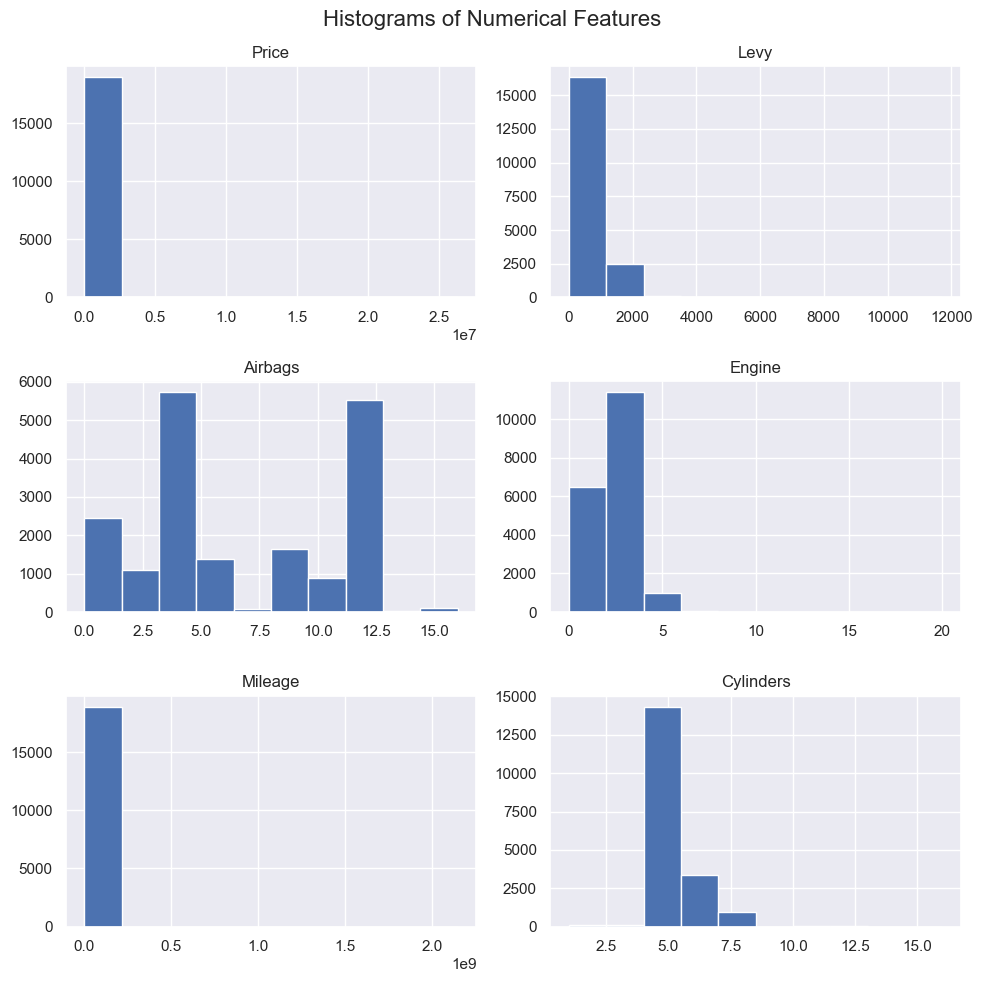

In [35]:
fig, axes = plt.subplots(3,2, figsize=(10, 10))

axes[0,0].hist(numerical_data['Price'])
axes[0,1].hist(numerical_data['Levy'])
axes[1,0].hist(numerical_data['Airbags'])
axes[1,1].hist(numerical_data['Engine volume'])
axes[2,0].hist(numerical_data['Mileage'])
axes[2,1].hist(numerical_data['Cylinders'])

axes[0, 0].set_title('Price')
axes[0, 1].set_title('Levy')
axes[1, 0].set_title('Airbags')
axes[1, 1].set_title('Engine')
axes[2, 0].set_title('Mileage')
axes[2, 1].set_title('Cylinders')

plt.suptitle('Histograms of Numerical Features', fontsize = 16)
plt.tight_layout()
plt.show()

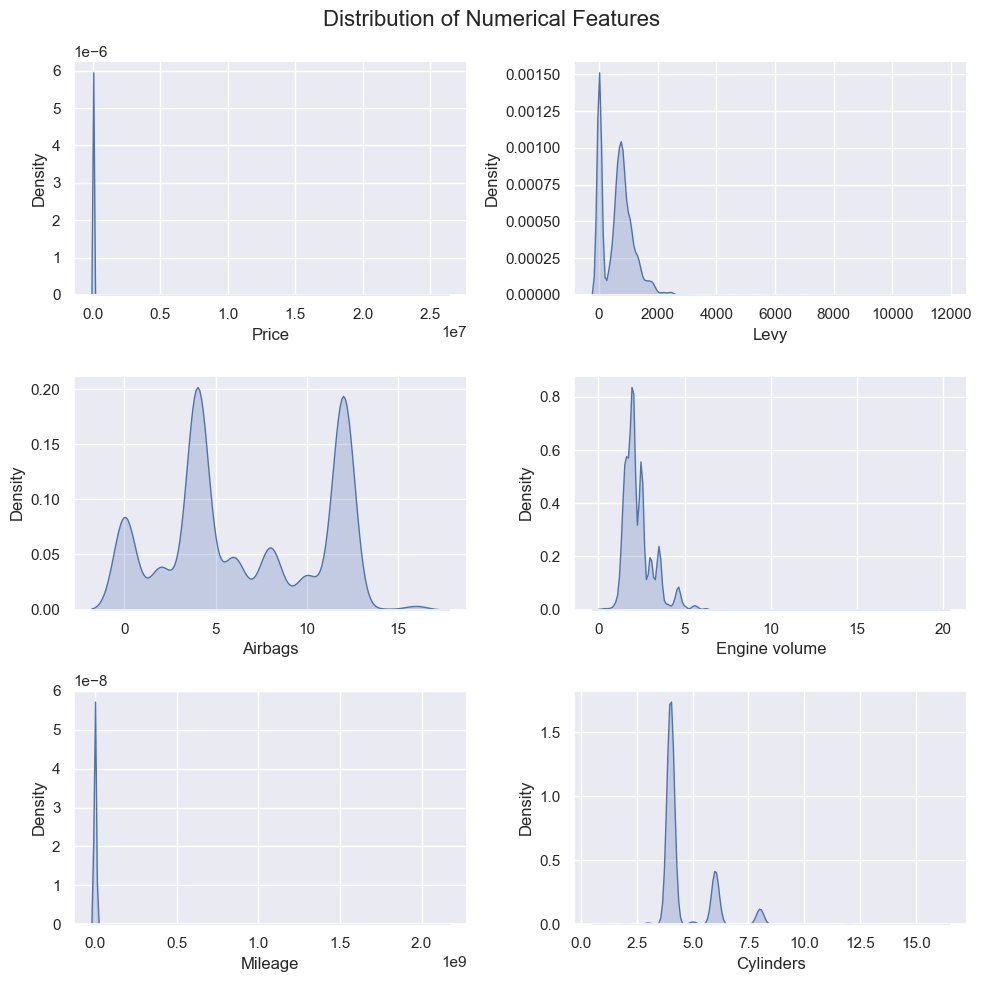

In [36]:
fig, axes = plt.subplots(3,2, figsize=(10, 10))

sns.kdeplot(numerical_data['Price'], fill=True, ax=axes[0,0])
sns.kdeplot(numerical_data['Levy'], fill=True, ax=axes[0,1])
sns.kdeplot(numerical_data['Airbags'], fill=True, ax=axes[1,0])
sns.kdeplot(numerical_data['Engine volume'], fill=True, ax=axes[1,1])
sns.kdeplot(numerical_data['Mileage'], fill=True, ax=axes[2,0])
sns.kdeplot(numerical_data['Cylinders'], fill=True, ax=axes[2,1])

fig.suptitle('Distribution of Numerical Features', fontsize=16)
plt.tight_layout()
plt.show()

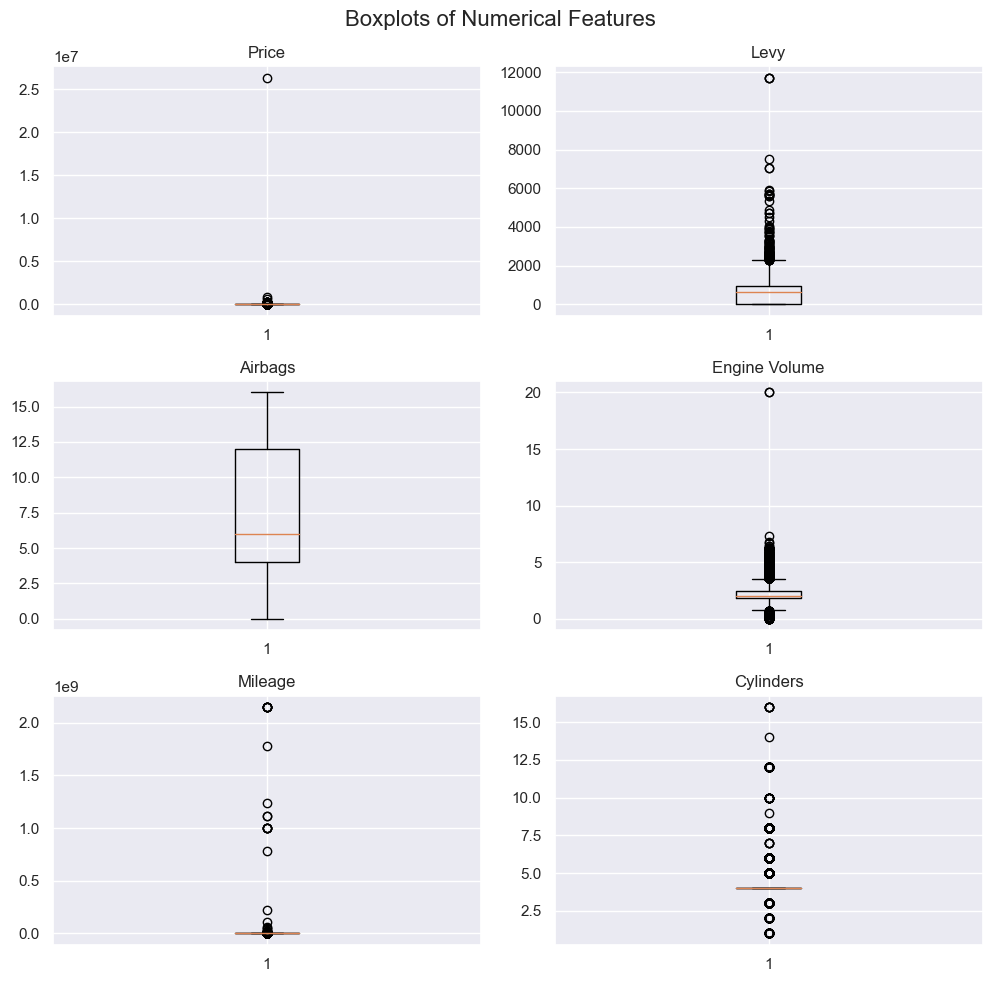

In [37]:
fig, axes = plt.subplots(3,2, figsize=(10, 10))

axes[0,0].boxplot(numerical_data['Price'])
axes[0,1].boxplot(numerical_data['Levy'])
axes[1,0].boxplot(numerical_data['Airbags'])
axes[1,1].boxplot(numerical_data['Engine volume'])
axes[2,0].boxplot(numerical_data['Mileage'])
axes[2,1].boxplot(numerical_data['Cylinders'])

axes[0, 0].set_title('Price')
axes[0, 1].set_title('Levy')
axes[1, 0].set_title('Airbags')
axes[1, 1].set_title('Engine Volume')
axes[2, 0].set_title('Mileage')
axes[2, 1].set_title('Cylinders')

plt.suptitle('Boxplots of Numerical Features', fontsize=16)
plt.tight_layout()
plt.show()

#### Price outliers

In [38]:
price_selected = numerical_data[numerical_data['Price']<100000]

In [39]:
len(price_selected)

18813

In [40]:
price_selected = price_selected.reset_index()

In [41]:
price_selected

,index,Price,Levy,Engine volume,Mileage,Cylinders,Airbags,age
0,0,13328,1399,3.5,186005.0,6.0,12,13
1,1,16621,1018,3.0,192000.0,6.0,8,12
2,2,8467,0,1.3,200000.0,4.0,2,17
3,3,3607,862,2.5,168966.0,4.0,0,12
4,4,11726,446,1.3,91901.0,4.0,4,9
...,...,...,...,...,...,...,...,...
18808,18919,8467,0,2.0,300000.0,4.0,5,24
18809,18920,15681,831,2.4,161600.0,4.0,8,12
18810,18921,26108,836,2.0,116365.0,4.0,4,13
18811,18922,5331,1288,2.0,51258.0,4.0,4,16


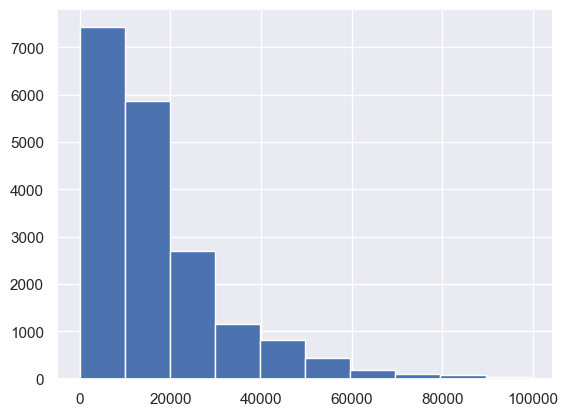

In [42]:
plt.hist(price_selected['Price'])
plt.show()

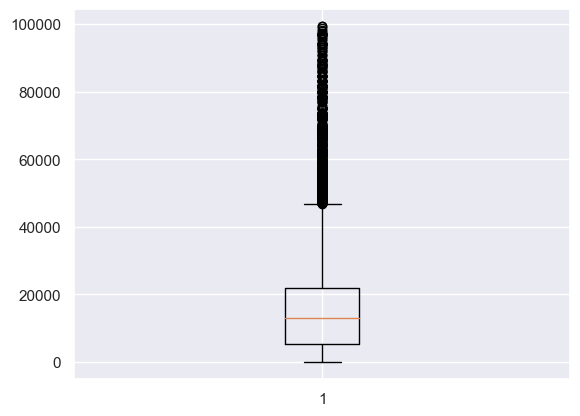

In [43]:
plt.boxplot(price_selected['Price'])
plt.show()

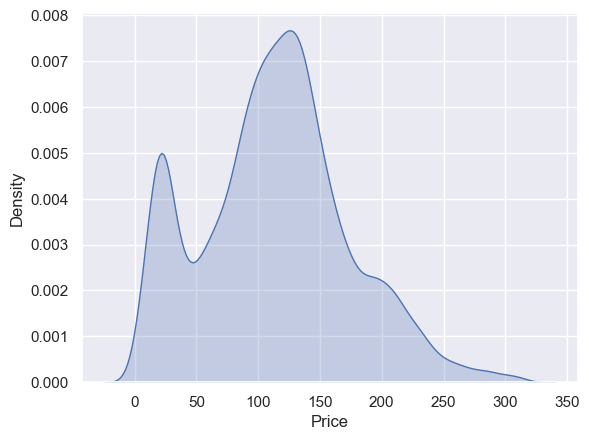

In [44]:
sns.kdeplot(np.sqrt(price_selected['Price']), fill=True)
plt.show()

#### Define class to calculate IQR

In [45]:
class IQR:
    def __init__(self, feature, data):
        self.feature = feature
        self.data = data

    def calculate_iqr(self):
        q1 = np.percentile(self.data[self.feature], 25)
        q3 = np.percentile(self.data[self.feature], 75)
        iqr = q3 - q1
        lower_limit = q1 - 1.5 * iqr
        upper_limit = q3 + 1.5 * iqr
        self.outliers = self.data[((self.data[self.feature] < lower_limit) | (self.data[self.feature] > upper_limit))]
        return  {
            'q1': q1,
            'q3': q3,
            'iqr': iqr,
            'lower_limit': lower_limit,
            'upper_limit': upper_limit
        }
        

In [46]:
numerical_data.columns

Index(['Price', 'Levy', 'Engine volume', 'Mileage', 'Cylinders', 'Airbags',
       'age'],
      dtype='object')

#### Levy Outliers

In [47]:
Levy_iqr = IQR('Levy', price_selected)

In [48]:
Levy_iqr.calculate_iqr()

{'q1': 0.0,
 'q3': 915.0,
 'iqr': 915.0,
 'lower_limit': -1372.5,
 'upper_limit': 2287.5}

In [49]:
Levy_iqr.outliers

,index,Price,Levy,Engine volume,Mileage,Cylinders,Airbags,age
18,18,549,2386,3.3,295059.0,6.0,12,17
26,26,549,2455,4.7,0.0,8.0,0,15
78,78,862,2455,4.7,263190.0,8.0,0,15
115,115,11917,11714,5.0,150000.0,12.0,12,20
132,132,549,2866,3.5,299709.0,6.0,12,19
...,...,...,...,...,...,...,...,...
18440,18550,282,2455,4.7,218126.0,8.0,0,15
18539,18650,14740,11706,5.0,56000.0,12.0,12,18
18545,18656,33,2308,3.7,185000.0,5.0,12,16
18564,18675,11917,11714,5.0,150000.0,12.0,12,20


In [50]:
Levy_iqr.outliers['Price'].values

array([  549,   549,   862, 11917,   549,   862,   282, 35438,   862,
         282, 11290,  9565, 27911, 28225, 35752,   314,  9095,  7840,
        3136,   314,   282,   314, 47042, 10349,  3150, 10036,  5331,
         282,   282,   392, 17249,  6272, 14740, 12000, 83251, 18000,
         862, 17562,   549, 14113, 20385, 13172,   862,   282,   862,
         314, 45000, 11760,   314,  7840,  5645, 25089, 26657,   282,
         314,   549, 58018, 28225,   314,   862,   862,   314,   392,
         314,   282, 11290,   862,  9400,   549, 72130, 12544, 28539,
       25089,   784, 10000,   627, 31988,   862,   627, 22266,  1254,
         392,   282,   862,   314,   282,   314,  8500,  2000,  6272,
         862,   282, 18000, 31675,   862, 31361,   282,   314, 18817,
         314,   862, 10506, 14113,   314, 56450, 28222,   941, 11290,
        9722,   549,  2744,   282,   627, 64290,   862, 35124,   314,
        7997,   862,   862,  7840, 13172, 17876, 10976, 17249,  6272,
       32302,  7840,

In [51]:
Levy_iqr.outliers.index

Index([   18,    26,    78,   115,   132,   490,   508,   698,   872,   926,
       ...
       17399, 17484, 18084, 18138, 18357, 18440, 18539, 18545, 18564, 18628],
      dtype='int64', length=156)

In [52]:
Levy_selected = price_selected.iloc[~price_selected.index.isin(Levy_iqr.outliers.index)]

In [53]:
Levy_selected

,index,Price,Levy,Engine volume,Mileage,Cylinders,Airbags,age
0,0,13328,1399,3.5,186005.0,6.0,12,13
1,1,16621,1018,3.0,192000.0,6.0,8,12
2,2,8467,0,1.3,200000.0,4.0,2,17
3,3,3607,862,2.5,168966.0,4.0,0,12
4,4,11726,446,1.3,91901.0,4.0,4,9
...,...,...,...,...,...,...,...,...
18808,18919,8467,0,2.0,300000.0,4.0,5,24
18809,18920,15681,831,2.4,161600.0,4.0,8,12
18810,18921,26108,836,2.0,116365.0,4.0,4,13
18811,18922,5331,1288,2.0,51258.0,4.0,4,16


In [54]:
len(Levy_selected)

18657

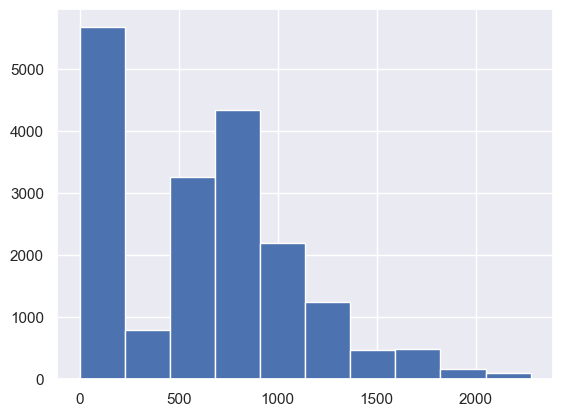

In [55]:
plt.hist(Levy_selected['Levy'])
plt.show()

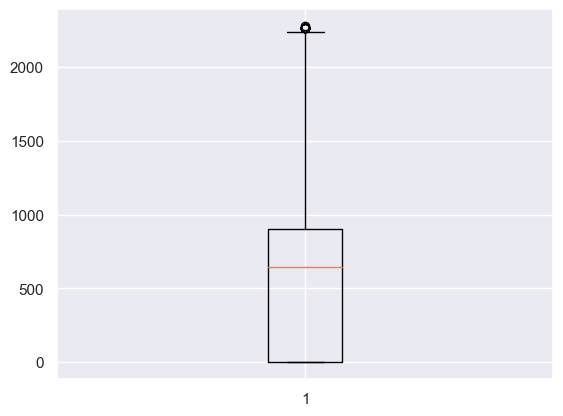

In [56]:
plt.boxplot(Levy_selected['Levy'])
plt.show()

In [57]:
numerical_data.columns

Index(['Price', 'Levy', 'Engine volume', 'Mileage', 'Cylinders', 'Airbags',
       'age'],
      dtype='object')

#### Mileage Outliers

In [58]:
Mileage_iqr = IQR('Mileage', Levy_selected)

In [59]:
Mileage_iqr.calculate_iqr()

{'q1': 70994.0,
 'q3': 189000.0,
 'iqr': 118006.0,
 'lower_limit': -106015.0,
 'upper_limit': 366009.0}

In [60]:
Mileage_iqr.outliers

,index,Price,Levy,Engine volume,Mileage,Cylinders,Airbags,age
8,8,1098,394,2.5,3.980690e+05,4.0,12,9
29,29,12074,1537,3.3,4.205500e+05,6.0,12,14
39,39,314,1399,3.5,3.827460e+05,6.0,12,13
65,65,9722,765,2.0,7.198470e+05,4.0,4,8
90,90,77775,1604,5.5,4.338110e+05,8.0,10,9
...,...,...,...,...,...,...,...,...
18742,18853,5018,645,1.8,4.895840e+05,4.0,12,12
18746,18857,18817,1995,2.4,2.147484e+09,4.0,2,20
18773,18884,500,0,2.5,7.600000e+05,4.0,2,25
18778,18889,3763,0,1.8,1.111111e+09,5.0,2,28


In [61]:
Mileage_iqr.outliers.describe()['Mileage']

count    6.410000e+02
mean     4.222611e+07
std      2.621143e+08
min      3.668690e+05
25%      3.980690e+05
50%      4.568670e+05
75%      5.954260e+05
max      2.147484e+09
Name: Mileage, dtype: float64

In [62]:
Mileage_selected = Levy_selected[Levy_selected['Mileage']<600000]

In [63]:
Mileage_selected

,index,Price,Levy,Engine volume,Mileage,Cylinders,Airbags,age
0,0,13328,1399,3.5,186005.0,6.0,12,13
1,1,16621,1018,3.0,192000.0,6.0,8,12
2,2,8467,0,1.3,200000.0,4.0,2,17
3,3,3607,862,2.5,168966.0,4.0,0,12
4,4,11726,446,1.3,91901.0,4.0,4,9
...,...,...,...,...,...,...,...,...
18808,18919,8467,0,2.0,300000.0,4.0,5,24
18809,18920,15681,831,2.4,161600.0,4.0,8,12
18810,18921,26108,836,2.0,116365.0,4.0,4,13
18811,18922,5331,1288,2.0,51258.0,4.0,4,16


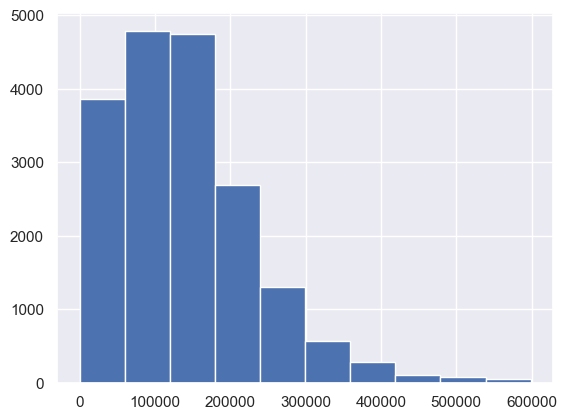

In [64]:
plt.hist(Mileage_selected['Mileage'])
plt.show()

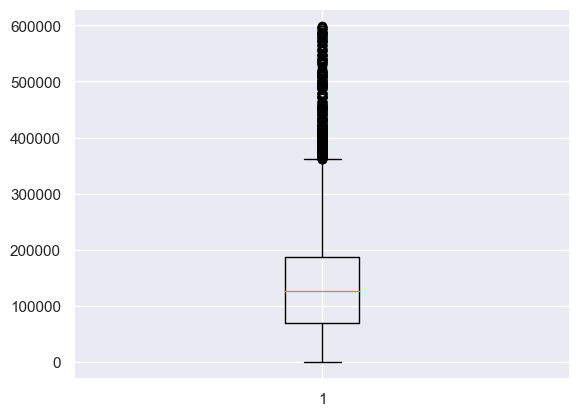

In [65]:
plt.boxplot(Mileage_selected['Mileage'])
plt.show()

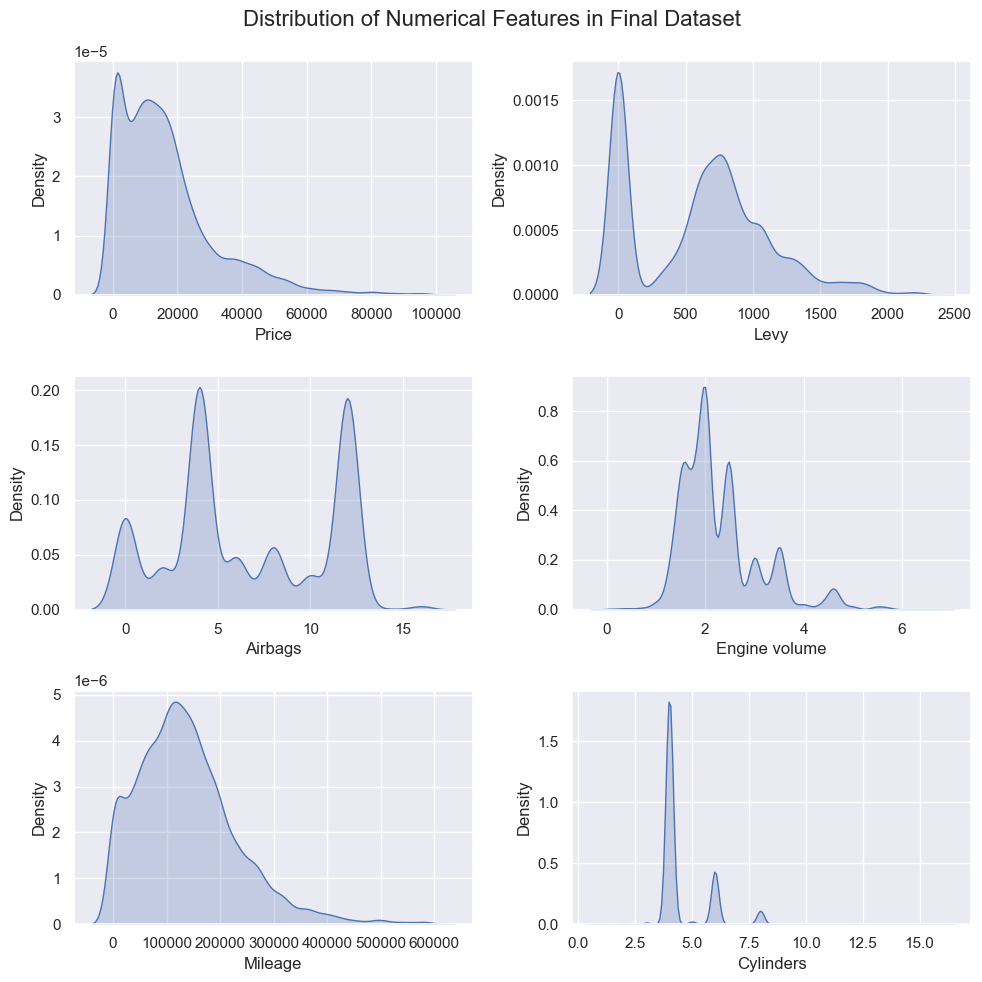

In [66]:
fig, axes = plt.subplots(3,2, figsize=(10, 10))

sns.kdeplot(Mileage_selected['Price'], fill=True, ax=axes[0,0])
sns.kdeplot(Mileage_selected['Levy'], fill=True, ax=axes[0,1])
sns.kdeplot(Mileage_selected['Airbags'], fill=True, ax=axes[1,0])
sns.kdeplot(Mileage_selected['Engine volume'], fill=True, ax=axes[1,1])
sns.kdeplot(Mileage_selected['Mileage'], fill=True, ax=axes[2,0])
sns.kdeplot(Mileage_selected['Cylinders'], fill=True, ax=axes[2,1])

fig.suptitle('Distribution of Numerical Features in Final Dataset', fontsize=16)
plt.tight_layout()
plt.show()

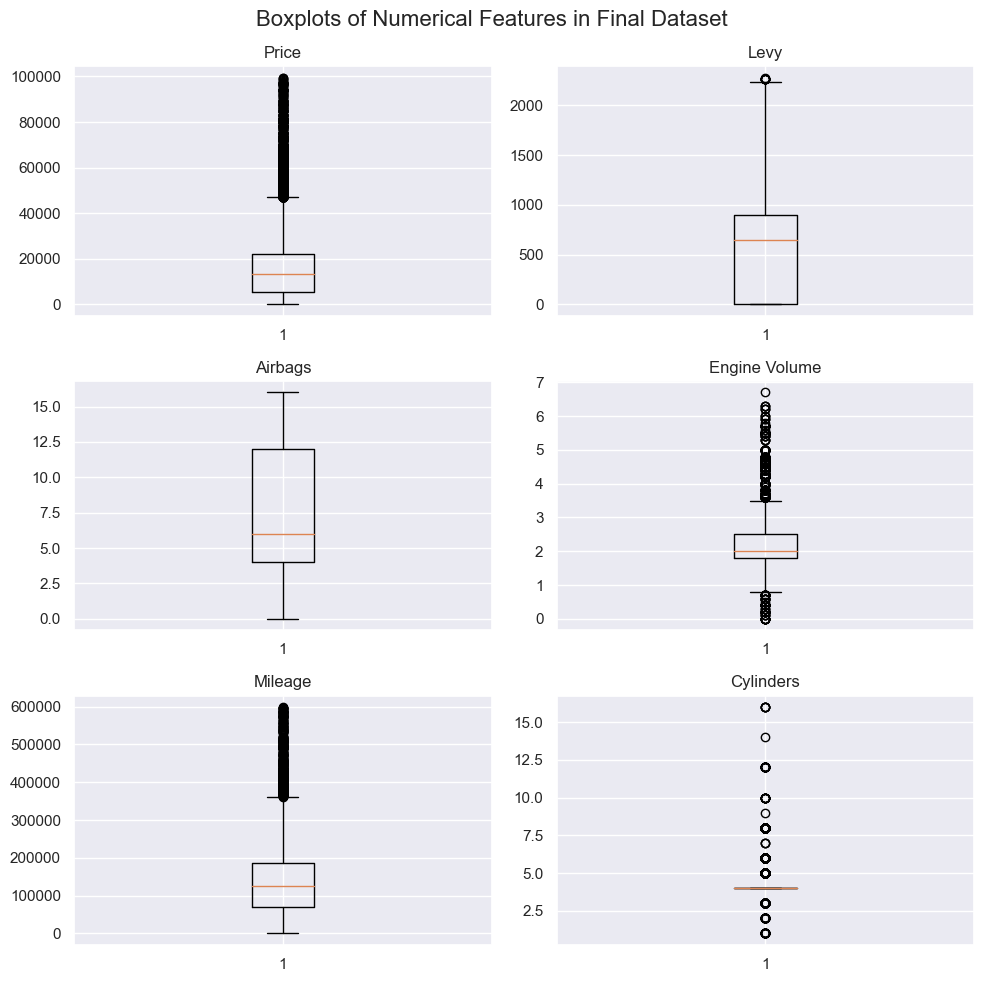

In [67]:
fig, axes = plt.subplots(3,2, figsize=(10, 10))

axes[0,0].boxplot(Mileage_selected['Price'])
axes[0,1].boxplot(Mileage_selected['Levy'])
axes[1,0].boxplot(Mileage_selected['Airbags'])
axes[1,1].boxplot(Mileage_selected['Engine volume'])
axes[2,0].boxplot(Mileage_selected['Mileage'])
axes[2,1].boxplot(Mileage_selected['Cylinders'])

axes[0, 0].set_title('Price')
axes[0, 1].set_title('Levy')
axes[1, 0].set_title('Airbags')
axes[1, 1].set_title('Engine Volume')
axes[2, 0].set_title('Mileage')
axes[2, 1].set_title('Cylinders')

plt.suptitle('Boxplots of Numerical Features in Final Dataset', fontsize=16)
plt.tight_layout()
plt.show()

* <font color = 'brown'>**All distributions looks better after outlier removal**</font>

In [69]:
numerical_selected = Mileage_selected.reset_index(drop=True)

In [70]:
numerical_selected

,index,Price,Levy,Engine volume,Mileage,Cylinders,Airbags,age
0,0,13328,1399,3.5,186005.0,6.0,12,13
1,1,16621,1018,3.0,192000.0,6.0,8,12
2,2,8467,0,1.3,200000.0,4.0,2,17
3,3,3607,862,2.5,168966.0,4.0,0,12
4,4,11726,446,1.3,91901.0,4.0,4,9
...,...,...,...,...,...,...,...,...
18496,18919,8467,0,2.0,300000.0,4.0,5,24
18497,18920,15681,831,2.4,161600.0,4.0,8,12
18498,18921,26108,836,2.0,116365.0,4.0,4,13
18499,18922,5331,1288,2.0,51258.0,4.0,4,16


In [71]:
numerical_selected['index'].values

array([    0,     1,     2, ..., 18921, 18922, 18923], dtype=int64)

In [72]:
categorical_data = categorical_data.iloc[numerical_selected['index'].values]

In [73]:
categorical_data = categorical_data.reset_index(drop=True)

In [74]:
categorical_data

,Manufacturer,Model,Category,Leather interior,Fuel type,Gear box type,Drive wheels,Doors,Wheel,Color
0,LEXUS,RX 450,Jeep,Yes,Hybrid,Automatic,4x4,4,Left wheel,Silver
1,CHEVROLET,Equinox,Jeep,No,Petrol,Tiptronic,4x4,4,Left wheel,Black
2,HONDA,FIT,Hatchback,No,Petrol,Variator,Front,4,Right-hand drive,Black
3,FORD,Escape,Jeep,Yes,Hybrid,Automatic,4x4,4,Left wheel,White
4,HONDA,FIT,Hatchback,Yes,Petrol,Automatic,Front,4,Left wheel,Silver
...,...,...,...,...,...,...,...,...,...,...
18496,MERCEDES-BENZ,CLK 200,Coupe,Yes,CNG,Manual,Rear,2,Left wheel,Silver
18497,HYUNDAI,Sonata,Sedan,Yes,Petrol,Tiptronic,Front,4,Left wheel,Red
18498,HYUNDAI,Tucson,Jeep,Yes,Diesel,Automatic,Front,4,Left wheel,Grey
18499,CHEVROLET,Captiva,Jeep,Yes,Diesel,Automatic,Front,4,Left wheel,Black


In [75]:
df2 = pd.concat([numerical_selected, categorical_data], axis=1)
df2.head()

,index,Price,Levy,Engine volume,Mileage,Cylinders,Airbags,age,Manufacturer,Model,Category,Leather interior,Fuel type,Gear box type,Drive wheels,Doors,Wheel,Color
0,0,13328,1399,3.5,186005.0,6.0,12,13,LEXUS,RX 450,Jeep,Yes,Hybrid,Automatic,4x4,4,Left wheel,Silver
1,1,16621,1018,3.0,192000.0,6.0,8,12,CHEVROLET,Equinox,Jeep,No,Petrol,Tiptronic,4x4,4,Left wheel,Black
2,2,8467,0,1.3,200000.0,4.0,2,17,HONDA,FIT,Hatchback,No,Petrol,Variator,Front,4,Right-hand drive,Black
3,3,3607,862,2.5,168966.0,4.0,0,12,FORD,Escape,Jeep,Yes,Hybrid,Automatic,4x4,4,Left wheel,White
4,4,11726,446,1.3,91901.0,4.0,4,9,HONDA,FIT,Hatchback,Yes,Petrol,Automatic,Front,4,Left wheel,Silver


In [76]:
df2.shape

(18501, 18)

## Handling Catogorical variables

In [134]:
categorical_data

,index,Manufacturer,Model,Category,Leather interior,Fuel type,Gear box type,Drive wheels,Doors,Wheel,Color
0,0,LEXUS,RX 450,Jeep,Yes,Hybrid,Automatic,4x4,4,Left wheel,Silver
1,1,CHEVROLET,Equinox,Jeep,No,Petrol,Tiptronic,4x4,4,Left wheel,Black
2,2,HONDA,FIT,Hatchback,No,Petrol,Variator,Front,4,Right-hand drive,Black
3,3,FORD,Escape,Jeep,Yes,Hybrid,Automatic,4x4,4,Left wheel,White
4,4,HONDA,FIT,Hatchback,Yes,Petrol,Automatic,Front,4,Left wheel,Silver
...,...,...,...,...,...,...,...,...,...,...,...
14844,18495,MERCEDES-BENZ,E 350,Sedan,Yes,Diesel,Automatic,Rear,4,Left wheel,Grey
14845,18497,HYUNDAI,Sonata,Sedan,Yes,Petrol,Tiptronic,Front,4,Left wheel,Red
14846,18498,HYUNDAI,Tucson,Jeep,Yes,Diesel,Automatic,Front,4,Left wheel,Grey
14847,18499,CHEVROLET,Captiva,Jeep,Yes,Diesel,Automatic,Front,4,Left wheel,Black


### Manufacturer

In [135]:
manufacturer_df = categorical_data['Manufacturer'].value_counts().to_frame()
manufacturer_df['percentage'] = np.round((manufacturer_df['count']/sum(manufacturer_df['count']))*100, 2)
manufacturer_df

,count,percentage
Manufacturer,,
HYUNDAI,3545,23.87
TOYOTA,3215,21.65
MERCEDES-BENZ,1424,9.59
CHEVROLET,909,6.12
FORD,898,6.05
HONDA,814,5.48
LEXUS,794,5.35
BMW,728,4.90
NISSAN,493,3.32


In [79]:
manufacturer_df[manufacturer_df['percentage']>1]

,count,percentage
Manufacturer,,
HYUNDAI,3664,19.80
TOYOTA,3564,19.26
MERCEDES-BENZ,1956,10.57
FORD,1061,5.73
CHEVROLET,1040,5.62
BMW,1002,5.42
HONDA,950,5.13
LEXUS,876,4.73
NISSAN,638,3.45


In [80]:
other_manufactures = manufacturer_df[manufacturer_df['percentage']<1]
other_manufactures

,count,percentage
Manufacturer,,
MAZDA,173,0.94
JEEP,134,0.72
DAEWOO,91,0.49
DODGE,82,0.44
FIAT,76,0.41
SUZUKI,75,0.41
MINI,47,0.25
VAZ,47,0.25
PORSCHE,43,0.23


In [81]:
other_manufactures.index

Index(['MAZDA', 'JEEP', 'DAEWOO', 'DODGE', 'FIAT', 'SUZUKI', 'MINI', 'VAZ',
       'PORSCHE', 'LAND ROVER', 'RENAULT', 'JAGUAR', 'INFINITI', 'CHRYSLER',
       'SKODA', 'VOLVO', 'PEUGEOT', 'BUICK', 'ACURA', 'LINCOLN', 'CADILLAC',
       'DAIHATSU', 'GAZ', 'GMC', 'UAZ', 'CITROEN', 'SCION', 'MASERATI',
       'ISUZU', 'ALFA ROMEO', 'HUMMER', 'MERCURY', 'ROVER', 'MOSKVICH', 'SAAB',
       'ROLLS-ROYCE', 'სხვა', 'SEAT', 'ZAZ', 'LANCIA', 'HAVAL', 'TESLA',
       'PONTIAC', 'SATURN', 'ASTON MARTIN', 'GREATWALL'],
      dtype='object', name='Manufacturer')

In [82]:
df2.pivot_table(values='Price', index='Manufacturer', aggfunc='mean').loc[other_manufactures.index]

,Price
Manufacturer,
MAZDA,9703.861272
JEEP,23998.477612
DAEWOO,6973.142857
DODGE,8538.743902
FIAT,11335.223684
SUZUKI,11960.213333
MINI,17481.765957
VAZ,4659.893617
PORSCHE,31859.581395


In [83]:
categorical_data = categorical_data[~categorical_data['Manufacturer'].isin(other_manufactures.index)]
len(categorical_data)

17355

### Model

In [84]:
model_df = categorical_data['Model'].value_counts().to_frame()
model_df['percentage'] = np.round((model_df['count']/sum(model_df['count']))*100, 2)
model_df

,count,percentage
Model,,
Prius,1059,6.10
Sonata,1013,5.84
Camry,927,5.34
Elantra,905,5.21
Santa FE,522,3.01
...,...,...
Sprinter VIP CLASS,1,0.01
A6 UNIVERSAL,1,0.01
Mustang cabrio,1,0.01


In [85]:
other_models = model_df[model_df['percentage']<0.1]
other_models

,count,percentage
Model,,
E 270,16,0.09
330,16,0.09
Accord,16,0.09
Elysion,15,0.09
C 240,14,0.08
...,...,...
Sprinter VIP CLASS,1,0.01
A6 UNIVERSAL,1,0.01
Mustang cabrio,1,0.01


In [86]:
categorical_data = categorical_data[~categorical_data['Model'].isin(other_models.index)]
len(categorical_data)

15017

In [87]:
category_df = categorical_data['Category'].value_counts().to_frame()
category_df['percentage'] = np.round((category_df['count']/sum(category_df['count']))*100, 2)
category_df

,count,percentage
Category,,
Sedan,6941,46.22
Jeep,4371,29.11
Hatchback,2337,15.56
Minivan,400,2.66
Universal,274,1.82
Coupe,272,1.81
Microbus,244,1.62
Goods wagon,159,1.06
Pickup,11,0.07


In [88]:
other_category = category_df[category_df['percentage']<0.1]
other_category

,count,percentage
Category,,
Pickup,11,0.07
Cabriolet,7,0.05
Limousine,1,0.01


In [89]:
categorical_data = categorical_data[~categorical_data['Category'].isin(other_category.index)]
len(categorical_data)

14998

In [90]:
categorical_data.columns

Index(['Manufacturer', 'Model', 'Category', 'Leather interior', 'Fuel type',
       'Gear box type', 'Drive wheels', 'Doors', 'Wheel', 'Color'],
      dtype='object')

### Fuel type

In [91]:
fuel_df = categorical_data['Fuel type'].value_counts().to_frame()
fuel_df['percentage'] = np.round((fuel_df['count']/sum(category_df['count']))*100, 2)
fuel_df

,count,percentage
Fuel type,,
Petrol,7161,47.69
Diesel,3454,23.00
Hybrid,3310,22.04
LPG,727,4.84
CNG,273,1.82
Plug-in Hybrid,73,0.49


In [92]:
categorical_data = categorical_data[~(categorical_data['Fuel type']=='Plug-in Hybrid')]

In [93]:
len(categorical_data)

14925

### Interior

In [94]:
interior_df = categorical_data['Leather interior'].value_counts().to_frame()
interior_df['percentage'] = np.round((interior_df['count']/sum(category_df['count']))*100, 2)
interior_df

,count,percentage
Leather interior,,
Yes,11257,74.96
No,3668,24.43


### Gearbox type

In [95]:
gearbox_df = categorical_data['Gear box type'].value_counts().to_frame()
gearbox_df['percentage'] = np.round((gearbox_df['count']/sum(category_df['count']))*100, 2)
gearbox_df

,count,percentage
Gear box type,,
Automatic,11296,75.22
Tiptronic,1940,12.92
Manual,1061,7.07
Variator,628,4.18


### Drive wheels

In [90]:
drivewheel_df = categorical_data['Drive wheels'].value_counts().to_frame()
drivewheel_df['percentage'] = np.round((drivewheel_df['count']/sum(category_df['count']))*100, 2)
drivewheel_df

,count,percentage
Drive wheels,,
Front,10665,71.02
4x4,2907,19.36
Rear,1353,9.01


### Doors

In [96]:
doors_df = categorical_data['Doors'].value_counts().to_frame()
doors_df['percentage'] = np.round((doors_df['count']/sum(category_df['count']))*100, 2)
doors_df

,count,percentage
Doors,,
4,14501,96.56
2,348,2.32
>5,76,0.51


In [97]:
categorical_data = categorical_data[~(categorical_data['Doors']=='>5')]

In [98]:
len(categorical_data)

14849

### Wheels

In [99]:
wheel_df = categorical_data['Wheel'].value_counts().to_frame()
wheel_df['percentage'] = np.round((wheel_df['count']/sum(category_df['count']))*100, 2)
wheel_df

,count,percentage
Wheel,,
Left wheel,13902,92.58
Right-hand drive,947,6.31


### Color

In [100]:
color_df = categorical_data['Color'].value_counts().to_frame()
color_df['percentage'] = np.round((color_df['count']/sum(category_df['count']))*100, 2)
color_df

,count,percentage
Color,,
Black,3827,25.48
White,3549,23.63
Silver,3033,20.20
Grey,1914,12.75
Blue,1034,6.89
Red,445,2.96
Orange,202,1.35
Green,196,1.31
Brown,134,0.89


In [101]:
categorical_data = categorical_data.reset_index()
categorical_data

,index,Manufacturer,Model,Category,Leather interior,Fuel type,Gear box type,Drive wheels,Doors,Wheel,Color
0,0,LEXUS,RX 450,Jeep,Yes,Hybrid,Automatic,4x4,4,Left wheel,Silver
1,1,CHEVROLET,Equinox,Jeep,No,Petrol,Tiptronic,4x4,4,Left wheel,Black
2,2,HONDA,FIT,Hatchback,No,Petrol,Variator,Front,4,Right-hand drive,Black
3,3,FORD,Escape,Jeep,Yes,Hybrid,Automatic,4x4,4,Left wheel,White
4,4,HONDA,FIT,Hatchback,Yes,Petrol,Automatic,Front,4,Left wheel,Silver
...,...,...,...,...,...,...,...,...,...,...,...
14844,18495,MERCEDES-BENZ,E 350,Sedan,Yes,Diesel,Automatic,Rear,4,Left wheel,Grey
14845,18497,HYUNDAI,Sonata,Sedan,Yes,Petrol,Tiptronic,Front,4,Left wheel,Red
14846,18498,HYUNDAI,Tucson,Jeep,Yes,Diesel,Automatic,Front,4,Left wheel,Grey
14847,18499,CHEVROLET,Captiva,Jeep,Yes,Diesel,Automatic,Front,4,Left wheel,Black


In [102]:
numerical_selected = numerical_selected.iloc[categorical_data['index'].values]

In [103]:
numerical_selected = numerical_selected.reset_index(drop=True)

In [104]:
numerical_selected

,index,Price,Levy,Engine volume,Mileage,Cylinders,Airbags,age
0,0,13328,1399,3.5,186005.0,6.0,12,13
1,1,16621,1018,3.0,192000.0,6.0,8,12
2,2,8467,0,1.3,200000.0,4.0,2,17
3,3,3607,862,2.5,168966.0,4.0,0,12
4,4,11726,446,1.3,91901.0,4.0,4,9
...,...,...,...,...,...,...,...,...
14844,18918,5802,1055,3.5,107800.0,6.0,12,10
14845,18920,15681,831,2.4,161600.0,4.0,8,12
14846,18921,26108,836,2.0,116365.0,4.0,4,13
14847,18922,5331,1288,2.0,51258.0,4.0,4,16


In [105]:
df3 = pd.concat([numerical_selected, categorical_data], axis=1)

In [106]:
df3.drop('index', axis=1, inplace=True)

In [107]:
df3.shape

(14849, 17)

In [108]:
df3.head()

,Price,Levy,Engine volume,Mileage,Cylinders,Airbags,age,Manufacturer,Model,Category,Leather interior,Fuel type,Gear box type,Drive wheels,Doors,Wheel,Color
0,13328,1399,3.5,186005.0,6.0,12,13,LEXUS,RX 450,Jeep,Yes,Hybrid,Automatic,4x4,4,Left wheel,Silver
1,16621,1018,3.0,192000.0,6.0,8,12,CHEVROLET,Equinox,Jeep,No,Petrol,Tiptronic,4x4,4,Left wheel,Black
2,8467,0,1.3,200000.0,4.0,2,17,HONDA,FIT,Hatchback,No,Petrol,Variator,Front,4,Right-hand drive,Black
3,3607,862,2.5,168966.0,4.0,0,12,FORD,Escape,Jeep,Yes,Hybrid,Automatic,4x4,4,Left wheel,White
4,11726,446,1.3,91901.0,4.0,4,9,HONDA,FIT,Hatchback,Yes,Petrol,Automatic,Front,4,Left wheel,Silver


### Visualize the categorical variables after handling

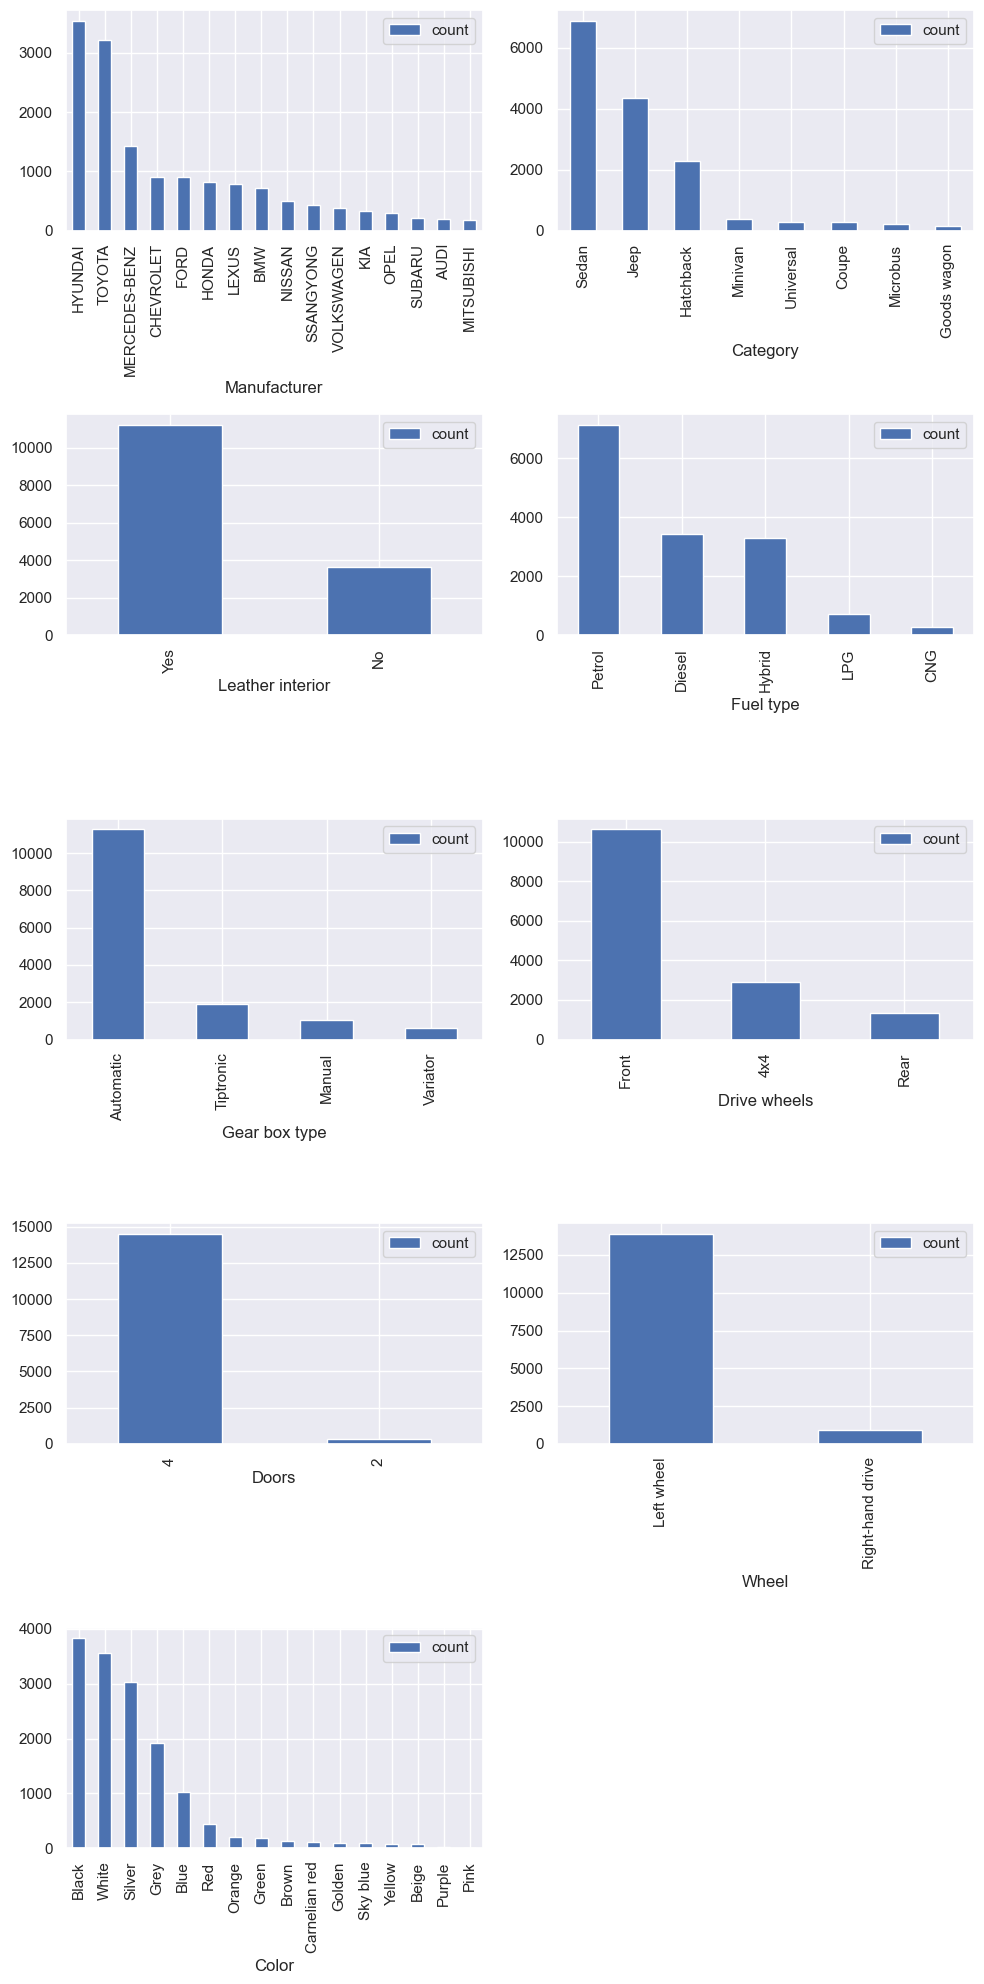

In [110]:
fig = plt.figure(figsize=(10,20))

ax1 = plt.subplot(5,2,1)
categorical_data['Manufacturer'].value_counts().to_frame().plot(kind = 'bar', ax=ax1)

ax2 = plt.subplot(5,2,2)
categorical_data['Category'].value_counts().to_frame().plot(kind = 'bar', ax=ax2)

ax3 = plt.subplot(5,2,3)
categorical_data['Leather interior'].value_counts().to_frame().plot(kind = 'bar', ax=ax3)

ax4 = plt.subplot(5,2,4)
categorical_data['Fuel type'].value_counts().to_frame().plot(kind = 'bar', ax=ax4)

ax5 = plt.subplot(5,2,5)
categorical_data['Gear box type'].value_counts().to_frame().plot(kind = 'bar', ax=ax5)

ax6 = plt.subplot(5,2,6)
categorical_data['Drive wheels'].value_counts().to_frame().plot(kind = 'bar', ax=ax6)

ax7 = plt.subplot(5,2,7)
categorical_data['Doors'].value_counts().to_frame().plot(kind = 'bar', ax=ax7)

ax8 = plt.subplot(5,2,8)
categorical_data['Wheel'].value_counts().to_frame().plot(kind = 'bar', ax=ax8)

ax9 = plt.subplot(5,2,9)
categorical_data['Color'].value_counts().to_frame().plot(kind = 'bar',ax=ax9)


plt.tight_layout()
plt.show()

In [111]:
df3_categorical = list(df3.columns[df3.dtypes=='object'])
df3_categorical

['Manufacturer',
 'Model',
 'Category',
 'Leather interior',
 'Fuel type',
 'Gear box type',
 'Drive wheels',
 'Doors',
 'Wheel',
 'Color']

## Visualize the variation of price among categorical features

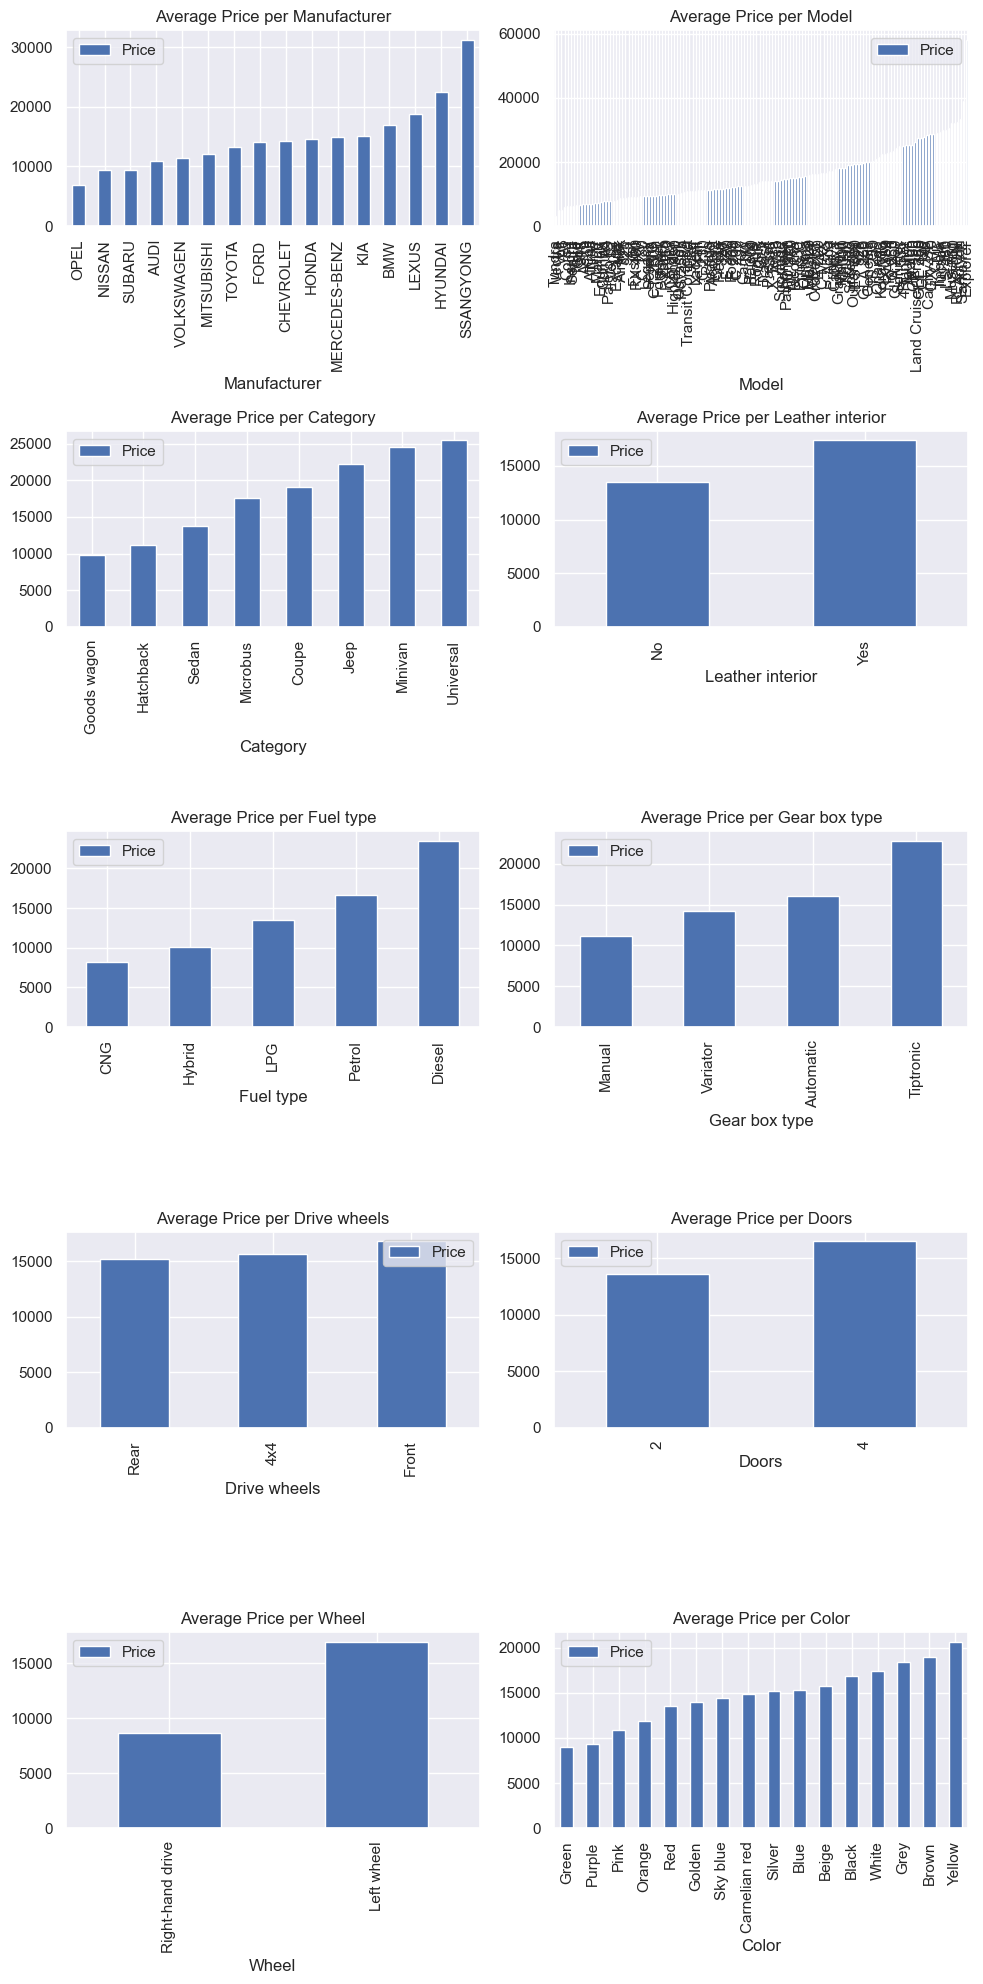

In [112]:
fig = plt.figure(figsize=(10,20))

for i in df3_categorical:
    ax = plt.subplot(5,2,df3_categorical.index(i)+1)
    df3.pivot_table(values='Price', index=i, aggfunc='mean').sort_values(by='Price').plot(kind='bar', ax=ax)
    plt.title('Average Price per {}'.format(i))
plt.tight_layout()
plt.show()

* <font color = 'brown'>**Looks like each categorical variable have a impact on price**</font>

In [113]:
df3_numerical = list(df3.columns[df3.dtypes!='object'])
df3_numerical

['Price', 'Levy', 'Engine volume', 'Mileage', 'Cylinders', 'Airbags', 'age']

## Visualize the variation of price with numerical features

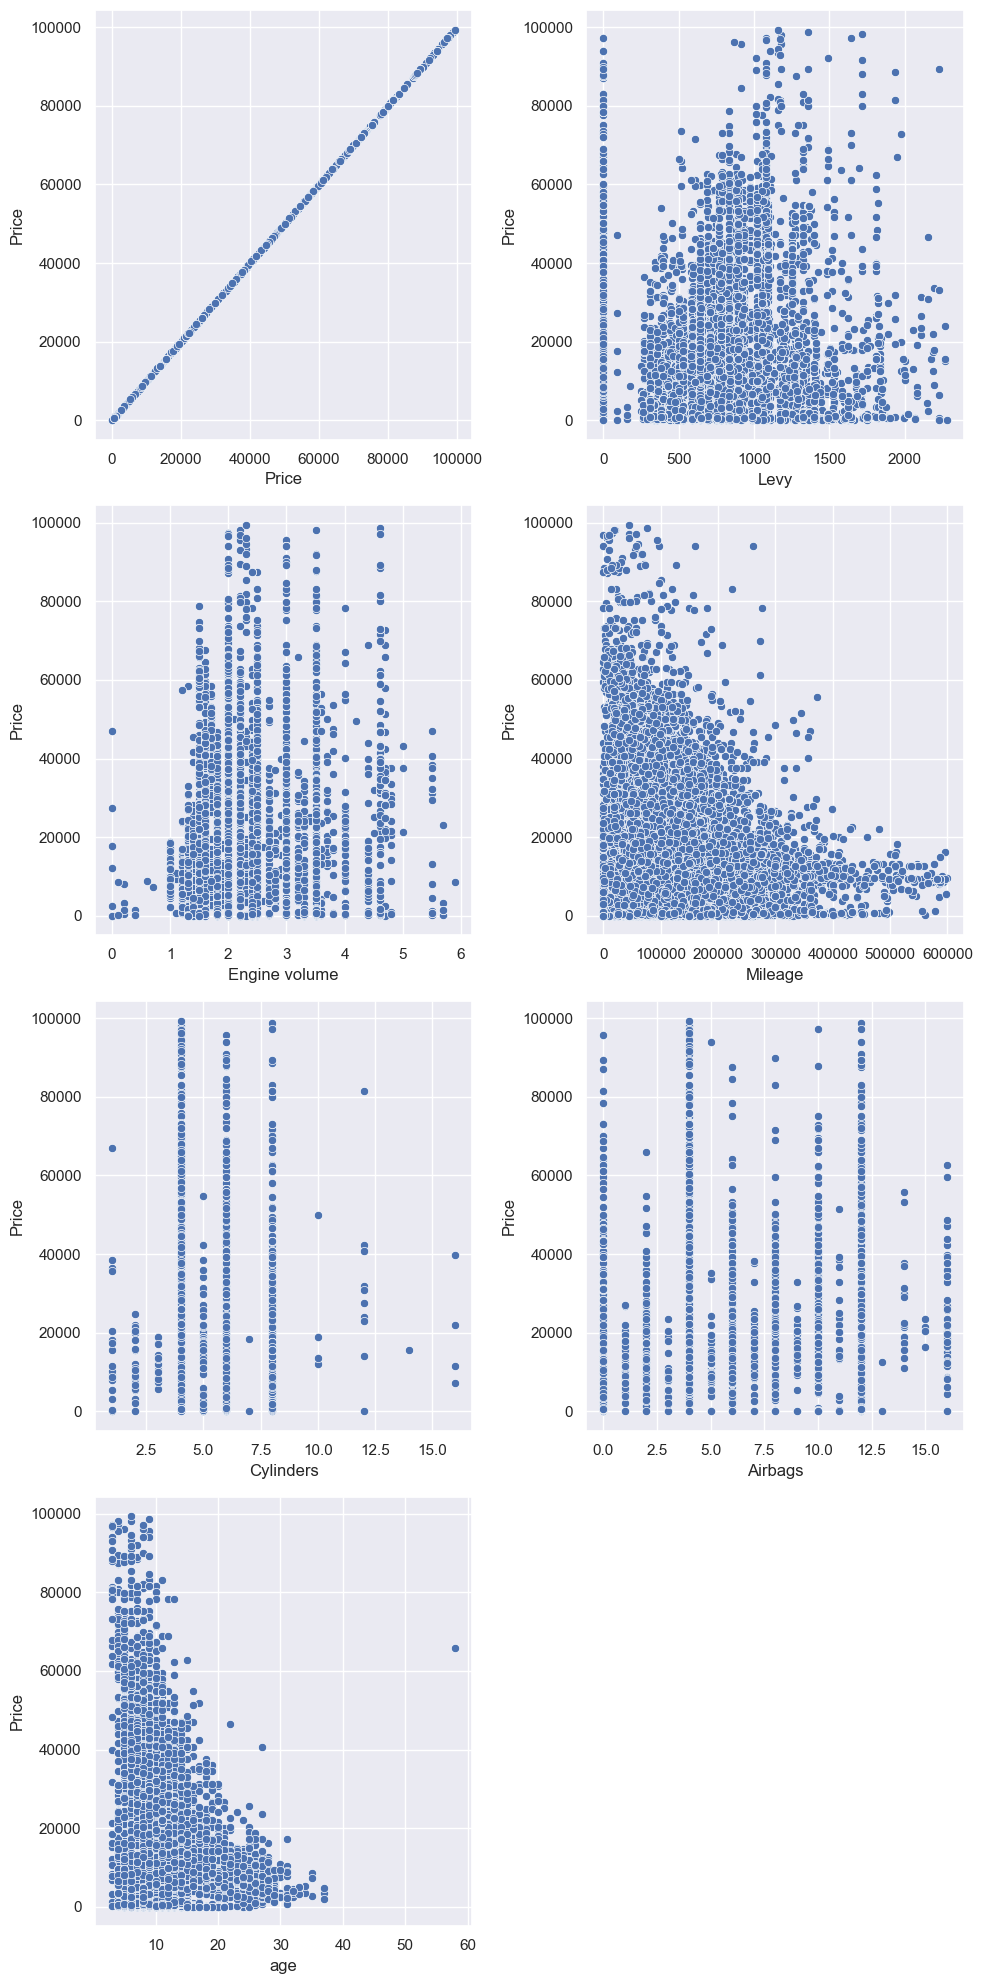

In [114]:
fig = plt.figure(figsize=(10,20))

for i in df3_numerical:
    ax = plt.subplot(4,2,df3_numerical.index(i)+1)
    sns.scatterplot(x=df3[i], y=df3['Price'], ax=ax)
    
plt.tight_layout()
plt.show()

* <font color = 'brown'>**Can not see any of feature linearly related with price**</font>

In [115]:
df3.head()

,Price,Levy,Engine volume,Mileage,Cylinders,Airbags,age,Manufacturer,Model,Category,Leather interior,Fuel type,Gear box type,Drive wheels,Doors,Wheel,Color
0,13328,1399,3.5,186005.0,6.0,12,13,LEXUS,RX 450,Jeep,Yes,Hybrid,Automatic,4x4,4,Left wheel,Silver
1,16621,1018,3.0,192000.0,6.0,8,12,CHEVROLET,Equinox,Jeep,No,Petrol,Tiptronic,4x4,4,Left wheel,Black
2,8467,0,1.3,200000.0,4.0,2,17,HONDA,FIT,Hatchback,No,Petrol,Variator,Front,4,Right-hand drive,Black
3,3607,862,2.5,168966.0,4.0,0,12,FORD,Escape,Jeep,Yes,Hybrid,Automatic,4x4,4,Left wheel,White
4,11726,446,1.3,91901.0,4.0,4,9,HONDA,FIT,Hatchback,Yes,Petrol,Automatic,Front,4,Left wheel,Silver


In [116]:
X = df3.iloc[:,1:]
y = df3['Price']

In [117]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=99)

## Handling highly correlated features

C:\Users\modhuka\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


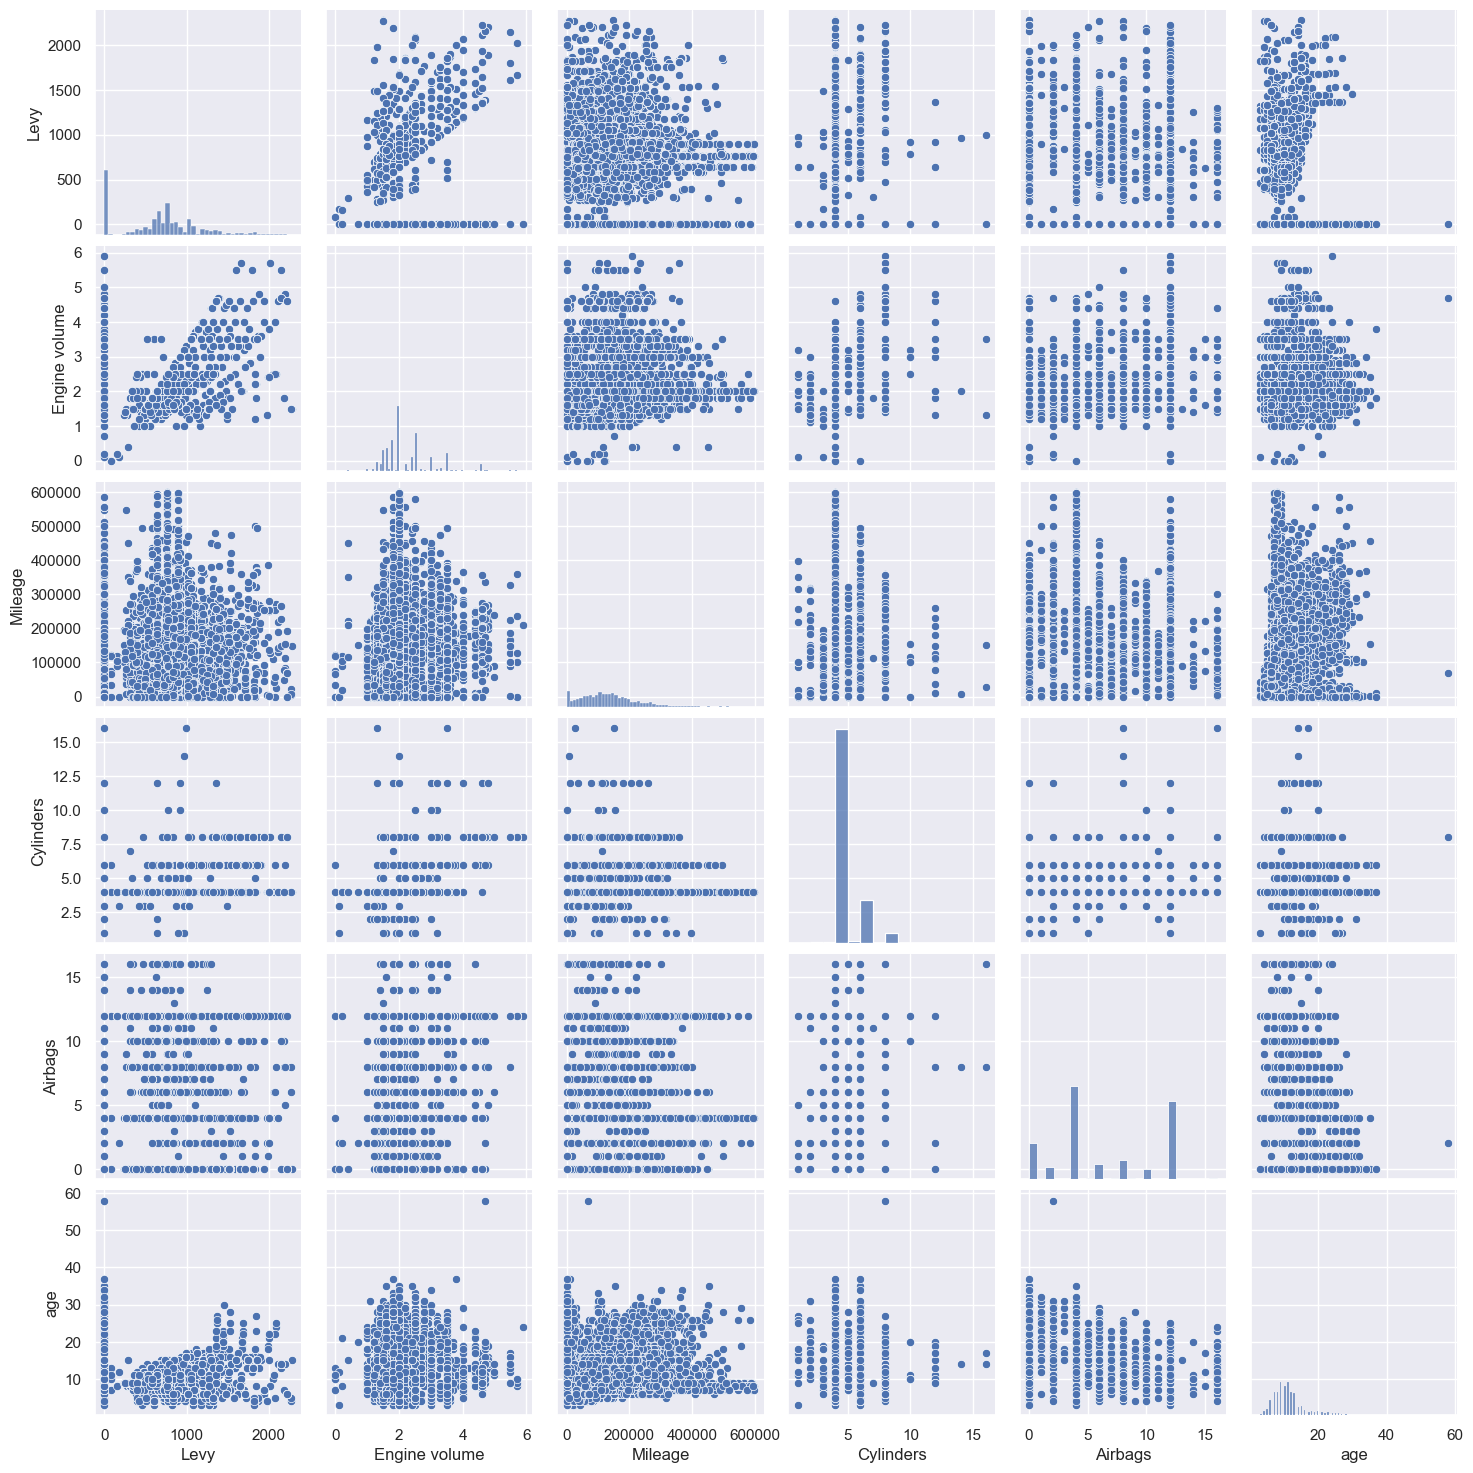

In [118]:
sns.pairplot(X_train)
plt.show()

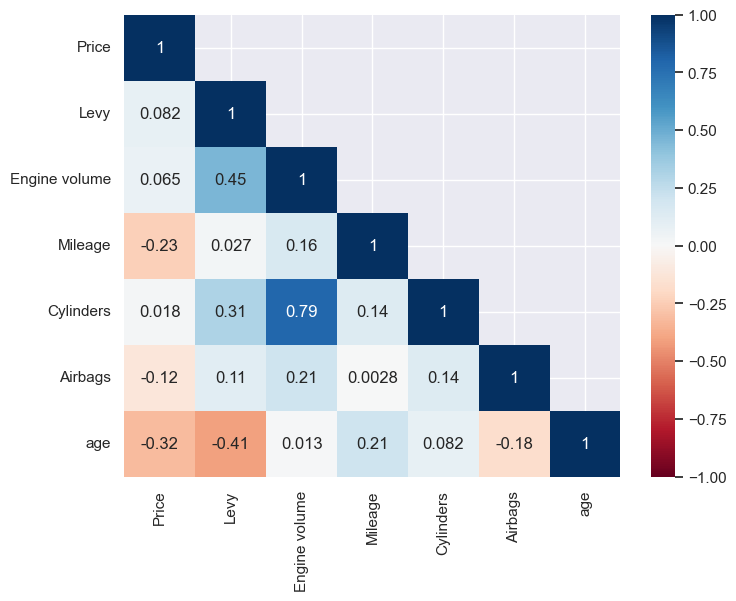

In [119]:
corr_matrix = df3.corr(numeric_only=True)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool),k=1)
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix,annot=True,cmap='RdBu',vmin=-1,vmax=1,mask=mask)
plt.show()

* <font color ='brown'>**Engine volume and Cylinders show somewhat positive relationship.**</font>

## Check the significance of numerical features

In [120]:
x_numeric_train = X_train.select_dtypes('number')
x = sm.add_constant(x_numeric_train)
results = sm.OLS(y_train,x).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.187
Model:                            OLS   Adj. R-squared:                  0.187
Method:                 Least Squares   F-statistic:                     455.6
Date:                Wed, 29 Nov 2023   Prob (F-statistic):               0.00
Time:                        13:19:26   Log-Likelihood:            -1.3002e+05
No. Observations:               11879   AIC:                         2.601e+05
Df Residuals:                   11872   BIC:                         2.601e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          3.374e+04    661.518     51.008      0.000    3.24e+04     3.5e+04
Levy             -4.4801      0.339    -13.231      0.000      -5.144      -3.816
Engine volume  4838.5407    293.503     16.486      0.000    4263.227    5413.854
Mileage          -0.0281      0.001    -20.938      0.000      -0.031      -0.025
Cylinders      -676.6917    194.354     -3.482      0.000   -1057.657    -295.727
Airbags        -766.0223     30.249    -25.324      0.000    -825.316    -706.729
age           -1173.2658     31.031    -37.809      0.000   -1234.092   -1112.439
==============================================================================
Omnibus:                     1992.329   Durbin-Watson:                   2.025
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4899.423
Skew:                           0.942   Prob(JB):                         0.00
Kurtosis:                       5.520   Cond. No.                     9.15e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.15e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

* <font color ='brown'>**Lokks like all numerical features are significance**</font>

In [121]:
x_numeric_train

,Levy,Engine volume,Mileage,Cylinders,Airbags,age
7795,919,3.0,171221.0,6.0,12,11
12071,781,2.5,159379.0,4.0,12,11
13245,833,2.2,280000.0,4.0,2,8
276,0,1.3,135000.0,4.0,4,21
10389,1750,3.3,287274.0,6.0,12,15
...,...,...,...,...,...,...
9929,0,2.5,300000.0,4.0,6,25
3240,0,3.0,81000.0,4.0,12,12
13497,585,1.8,125000.0,4.0,12,10
7203,1399,3.5,197044.0,6.0,12,13


In [122]:
mutual_info = mutual_info_regression(x_numeric_train, y_train)
mutual_info = pd.Series(mutual_info)
mutual_info.index = x_numeric_train.columns
mutual_info.sort_values(ascending=False)

Levy             0.920317
Mileage          0.913040
Airbags          0.464872
age              0.456728
Engine volume    0.430078
Cylinders        0.111866
dtype: float64

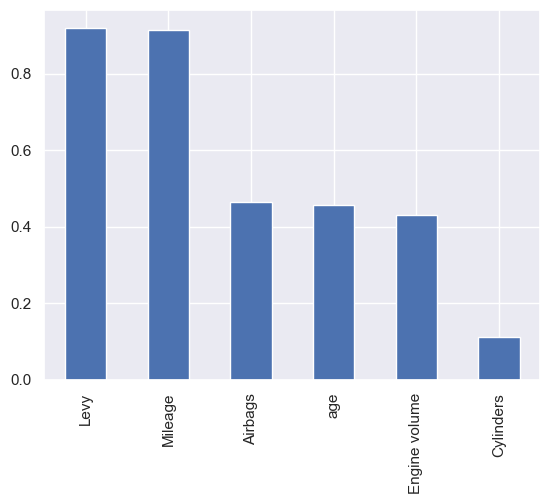

In [123]:
mutual_info.sort_values(ascending=False).plot(kind='bar')
plt.show()

## Data Preprossessing

In [136]:
categorical_preprocessor = Pipeline(
    steps = [('ohe', OneHotEncoder(drop='first'))]
)

In [137]:
numerical_preprocessor = Pipeline(
    steps = [('minmaxscaler' , MinMaxScaler())]
)

In [138]:
preprocessor = ColumnTransformer(
    [('categorical', categorical_preprocessor, list(X_train.select_dtypes('object').columns)),
    ('numerical', numerical_preprocessor, list(X_train.select_dtypes('number').columns))]   
)

In [139]:
preprocessor

ColumnTransformer(transformers=[('categorical',
                                 Pipeline(steps=[('ohe',
                                                  OneHotEncoder(drop='first'))]),
                                 ['Manufacturer', 'Model', 'Category',
                                  'Leather interior', 'Fuel type',
                                  'Gear box type', 'Drive wheels', 'Doors',
                                  'Wheel', 'Color']),
                                ('numerical',
                                 Pipeline(steps=[('minmaxscaler',
                                                  MinMaxScaler())]),
                                 ['Levy', 'Engine volume', 'Mileage',
                                  'Cylinders', 'Airbags', 'age'])])

In [140]:
X_train_preproccessed = preprocessor.fit_transform(X_train)
X_test_preproccessed = preprocessor.transform(X_test)

In [141]:
X_train_preproccessed.shape

(11879, 190)

In [142]:
cval = KFold(n_splits=5, shuffle=True, random_state=99)

# Model Building

## Model Selection

### Linear Regression

In [145]:
lr = LinearRegression()

In [146]:
errors_lr = -cross_val_score(estimator=lr,                  
                X=X_train_preproccessed,
                y=y_train,
                cv=cval,
                scoring='neg_root_mean_squared_error')

print('Errors {}'.format(errors_lr))
print()
print('Avg_error {}'.format(np.mean(errors_lr)))

Errors [11378.40443785 11058.39446706 11060.03480392 11061.88917597
 11634.4244911 ]

Avg_error 11238.629475181595


### KNeighbours

#### find best number of neighbours

In [147]:
neighbors = []
errors = []

for i in range(1, 20):
    knn = KNeighborsRegressor(n_neighbors=i)
    model = knn.fit(X_train_preproccessed, y_train)
    error = np.mean(-cross_val_score(estimator=model,                  
                        X=X_train_preproccessed,
                        y=y_train,
                        cv=cval,
                        scoring='neg_root_mean_squared_error'))
    neighbors.append(i)
    errors.append(error)
    


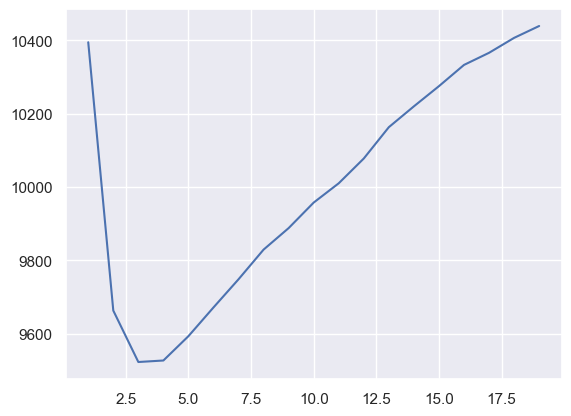

In [148]:
plt.plot(neighbors, errors)
plt.show()

In [152]:
np.argmin(errors)+1

3

In [158]:
knn = KNeighborsRegressor(n_neighbors=3)

In [159]:
errors_knn = -cross_val_score(estimator=knn,                  
                 X=X_train_preproccessed,
                 y=y_train,
                 cv=5,
                 scoring='neg_root_mean_squared_error')

print('Errors {}'.format(errors_knn))
print()
print('Avg_error {}'.format(np.mean(errors_knn)))

Errors [9024.70224618 9457.45553742 9911.68089112 9680.59906804 9594.14515717]

Avg_error 9533.716579984495


### Decision Tree

In [160]:
dt = DecisionTreeRegressor(random_state=99)

In [161]:
errors_dt = -cross_val_score(estimator=dt,                  
                 X=X_train_preproccessed,
                 y=y_train,
                 cv=cval,
                 scoring='neg_root_mean_squared_error')

print('Errors {}'.format(errors_dt))
print()
print('Avg_error {}'.format(np.mean(errors_dt)))

Errors [8751.1221268  8272.44112562 8484.90086814 8682.35461498 9123.34015547]

Avg_error 8662.831778201153


### Random Forest

In [162]:
rf = RandomForestRegressor(random_state=99)

In [163]:
errors_rf = -cross_val_score(estimator=rf,                  
                 X=X_train_preproccessed,
                 y=y_train,
                 cv=cval,
                 scoring='neg_root_mean_squared_error')

print('Errors {}'.format(errors_rf))
print()
print('Avg_error {}'.format(np.mean(errors_rf)))

Errors [6880.57258734 6286.11887264 6715.7237502  6570.20199464 6756.82841373]

Avg_error 6641.889123709584


In [164]:
svr = SVR()

In [165]:
errors_svr = -cross_val_score(estimator=svr,                  
                 X=X_train_preproccessed,
                 y=y_train,
                 cv=cval,
                 scoring='neg_root_mean_squared_error')

print('Errors {}'.format(errors_svr))
print()
print('Avg_error {}'.format(np.mean(errors_svr)))

Errors [15711.13669747 15164.25064973 15295.86575795 15322.58260726
 15735.52669842]

Avg_error 15445.872482164166


<font color = 'brown'>**Random forest is the best performing Model**</font>

# Hyper parameter Tuning

In [166]:
rf = RandomForestRegressor(random_state=99)

In [179]:
parameters = {
    'n_estimators': range(50,501),
    'max_features':['sqrt', 'log2', None],
    'bootstrap':[True, False],
    'min_samples_split':range(2,101) 
}

In [182]:
randomsearch = RandomizedSearchCV(
                estimator= rf,
                param_distributions= parameters,
                n_iter= 100,
                cv= cval,
                scoring='neg_root_mean_squared_error',
                verbose=2
                )

In [183]:
randomsearch.fit(X_train_preproccessed,y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END bootstrap=False, max_features=log2, min_samples_split=89, n_estimators=410; total time=   7.6s
[CV] END bootstrap=False, max_features=log2, min_samples_split=89, n_estimators=410; total time=   7.6s
[CV] END bootstrap=False, max_features=log2, min_samples_split=89, n_estimators=410; total time=   7.6s
[CV] END bootstrap=False, max_features=log2, min_samples_split=89, n_estimators=410; total time=   7.9s
[CV] END bootstrap=False, max_features=log2, min_samples_split=89, n_estimators=410; total time=   7.9s
[CV] END bootstrap=True, max_features=sqrt, min_samples_split=38, n_estimators=241; total time=   8.1s
[CV] END bootstrap=True, max_features=sqrt, min_samples_split=38, n_estimators=241; total time=   7.9s
[CV] END bootstrap=True, max_features=sqrt, min_samples_split=38, n_estimators=241; total time=   8.0s
[CV] END bootstrap=True, max_features=sqrt, min_samples_split=38, n_estimators=241; total time=   9.9s
[CV] 

RandomizedSearchCV(cv=KFold(n_splits=5, random_state=99, shuffle=True),
                   estimator=RandomForestRegressor(random_state=99), n_iter=100,
                   param_distributions={'bootstrap': [True, False],
                                        'max_features': ['sqrt', 'log2', None],
                                        'min_samples_split': range(2, 101),
                                        'n_estimators': range(50, 501)},
                   scoring='neg_root_mean_squared_error', verbose=2)

In [244]:
randomsearch.best_params_

{'n_estimators': 487,
 'min_samples_split': 13,
 'max_features': None,
 'bootstrap': True}

In [245]:
randomsearch.best_score_

-6827.553118097478

In [246]:
model = randomsearch.best_estimator_
model

RandomForestRegressor(max_features=None, min_samples_split=13, n_estimators=487,
                      random_state=99)

In [248]:
model.fit(X_train_preproccessed, y_train)

RandomForestRegressor(max_features=None, min_samples_split=13, n_estimators=487,
                      random_state=99)

In [249]:
model.score(X_train_preproccessed, y_train)

0.9140372692945913

In [250]:
model.score(X_test_preproccessed, y_test)

0.7717241553272626

In [251]:
predicted = model.predict(X_test_preproccessed)

In [253]:
np.sqrt(mean_squared_error(y_test, predicted))

7478.426994923928

In [264]:
errors = y_test - predicted

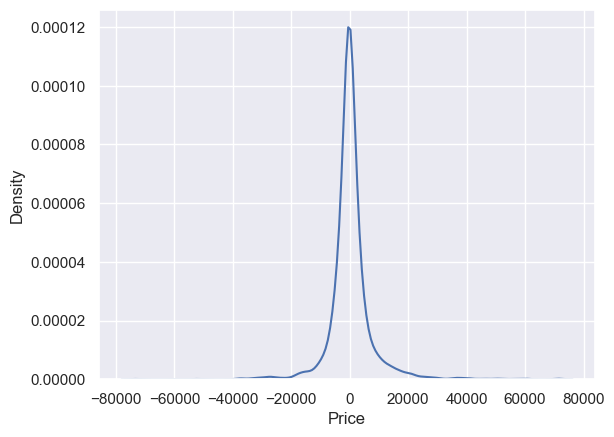

In [266]:
sns.kdeplot(errors)
plt.show()

* <font color = 'brown'>**Errors are normally ditributed around mean zero**</font>

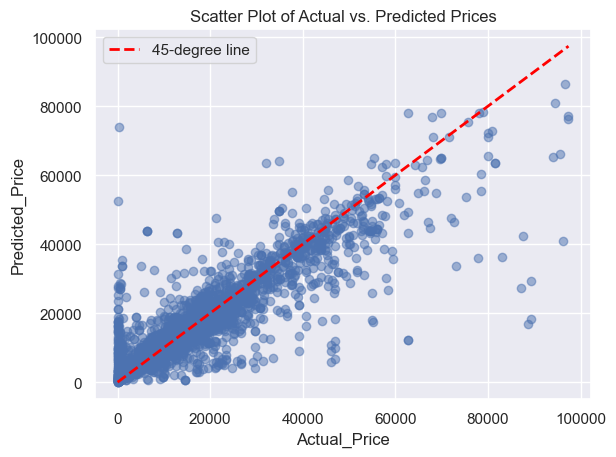

In [271]:
plt.scatter(y_test, predicted, alpha=0.5) 
plt.xlabel('Actual_Price')
plt.ylabel('Predicted_Price')
plt.title('Scatter Plot of Actual vs. Predicted Prices')

plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', lw=2, label='45-degree line')

plt.xlabel('Actual_Price')
plt.ylabel('Predicted_Price')
plt.legend()

plt.show()

* <font color = 'brown'>**Most data points are around 45 degree line**</font>

## Try without Color feature

In [254]:
X_train_new = X_train.drop('Color', axis=1)
X_test_new = X_test.drop('Color', axis=1)

In [255]:
X_test_new

,Levy,Engine volume,Mileage,Cylinders,Airbags,age,Manufacturer,Model,Category,Leather interior,Fuel type,Gear box type,Drive wheels,Doors,Wheel
5507,730,1.6,72073.0,4.0,4,7,SSANGYONG,Actyon,Jeep,Yes,Petrol,Automatic,Front,4,Left wheel
8567,919,3.0,103458.0,6.0,0,11,BMW,X5,Jeep,Yes,Diesel,Automatic,4x4,4,Left wheel
5347,781,2.5,361035.0,4.0,12,11,TOYOTA,Camry,Sedan,Yes,Hybrid,Automatic,Front,4,Left wheel
7433,1185,2.5,99000.0,4.0,7,14,FORD,Escape,Jeep,No,Hybrid,Automatic,Front,4,Left wheel
4015,2151,4.7,264339.0,8.0,0,14,LEXUS,GX 470,Jeep,Yes,Petrol,Automatic,4x4,4,Left wheel
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11770,777,2.5,68200.0,4.0,6,9,NISSAN,Rogue,Jeep,Yes,Petrol,Variator,4x4,4,Left wheel
13249,0,2.2,115000.0,4.0,4,22,BMW,320,Sedan,No,Petrol,Automatic,Front,4,Right-hand drive
387,1172,3.5,119379.0,6.0,12,12,MERCEDES-BENZ,E 350,Sedan,Yes,Diesel,Automatic,4x4,4,Left wheel
2444,0,1.5,79500.0,4.0,10,8,TOYOTA,Prius C,Sedan,Yes,Hybrid,Automatic,Front,4,Left wheel


In [256]:
preprocessor_new = ColumnTransformer(
    [('categorical', categorical_preprocessor, list(X_train_new.select_dtypes('object').columns)),
    ('numerical', numerical_preprocessor, list(X_train_new.select_dtypes('number').columns))]   
)

In [257]:
X_train_preproccessed_new = preprocessor_new.fit_transform(X_train_new)
X_test_preproccessed_new = preprocessor_new.transform(X_test_new)

In [258]:
model_new = RandomForestRegressor(n_estimators=487,
                                 min_samples_split=13,
                                 max_features=None,
                                 bootstrap=True,
                                 random_state=99)

In [259]:
model_new.fit(X_train_preproccessed_new, y_train)

RandomForestRegressor(max_features=None, min_samples_split=13, n_estimators=487,
                      random_state=99)

In [260]:
model_new.score(X_train_preproccessed_new, y_train)

0.9106114579494123

In [261]:
model_new.score(X_test_preproccessed_new, y_test)

0.7700964617480853

In [262]:
predicted_new = model_new.predict(X_test_preproccessed_new)

In [263]:
np.sqrt(mean_squared_error(y_test, predicted_new))

7505.041650193451

* <font color = 'brown'>**does not have any improvement**</font>